In [1]:
pwd

'c:\\Users\\xavie\\P7\\P7_ML_model'

# 1 Intro

Notebook dédié à l'entrainement du modèle de ML
- sur base application_train (train_V1.csv)
- dummy classifier
- modèles de classification: Regression Logistique, Random Forest, LGBM, XGBooost
- transformation des variables catégorielles via OneHotEncoder puis via booléen (quand possible)
- gestion de classes non équilibrées(RandomUnderSampler)


## 1.1. Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline_imb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from xgboost import XGBClassifier
import xgboost as xgb
import mlflow
from mlflow import log_metric, log_param, log_artifacts, log_metrics
from mlflow.models import infer_signature
from mlflow.sklearn import log_model
import os
import tempfile
import datetime
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')

## 1.2 Fonctions utiles / set-up

In [46]:
from src.fonctions import *

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
DISPLAY=True

"""If Dispaly == False then all cell starting starting with 'If Display=True' won't be ran.
Else they will

This short function allows to by-pass instructions which are long to run (ex MSNO on huge dataset or sns.pairplot)"""

"If Dispaly == False then all cell starting starting with 'If Display=True' won't be ran.\nElse they will\n\nThis short function allows to by-pass instructions which are long to run (ex MSNO on huge dataset or sns.pairplot)"

# 2 Data

## 2.1 Import and display

In [6]:
train_V1=pd.read_csv('../train_V1.csv')

In [7]:
train_V1.shape

(307490, 23)

In [8]:
train_V1.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,OWN_CAR_AGE,FLAG_OWN_REALTY,NAME_HOUSING_TYPE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
0,100002,1,0,NaN,1,House / apartment,202500.0,406597.5,24700.5,351000.0,Working,Single / not married,Secondary / secondary special,1.0,0.083037,0.262949,0.139376,25,2.0,1,0,1,0
1,100003,0,0,NaN,0,House / apartment,270000.0,1293502.5,35698.5,1129500.0,State servant,Married,Higher education,2.0,0.311267,0.622246,NaN,45,3.0,1,1,1,1
2,100004,0,1,26.0,1,House / apartment,67500.0,135000.0,6750.0,135000.0,Working,Single / not married,Secondary / secondary special,1.0,NaN,0.555912,0.729567,52,1.0,0,0,1,0
3,100006,0,0,NaN,1,House / apartment,135000.0,312682.5,29686.5,297000.0,Working,Civil marriage,Secondary / secondary special,2.0,NaN,0.650442,NaN,52,8.0,1,1,1,1
4,100007,0,0,NaN,1,House / apartment,121500.0,513000.0,21865.5,513000.0,Working,Single / not married,Secondary / secondary special,1.0,NaN,0.322738,NaN,54,8.0,1,0,1,0


Select only 20% du dataset pour accelerer divers fits ci dessous

In [9]:
train_V1=train_V1.sample(frac=0.2)
train_V1.shape

(61498, 23)

# 3 Phase 0: MachineLearning / Baseline
- Sur base Application Train
- Dummy Classifier

## 3.1. Séparation du jeu de données (features: X / target:y)
 et suppression de colonnes inutiles

In [10]:
X=train_V1.drop(['SK_ID_CURR','TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','active_client','relationship'],axis=1)
X.shape

(61498, 16)

In [11]:
y=train_V1['TARGET']
y.shape

(61498,)

In [12]:
num_feat=X.select_dtypes(exclude=object).columns.to_list()
num_feat

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'client_age',
 'client_prof_exp',
 'Cash_loans',
 'GENDER_FEMALE']

In [13]:
cat_feat=X.select_dtypes(include=object).columns.to_list()
cat_feat

['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE']

## 3.2 Train-test split

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [15]:
print('Train set:',X_train.shape)
print('Test set:',X_test.shape)
print('Train target:',y_train.shape)
print('Test target:',y_test.shape)

Train set: (49198, 16)
Test set: (12300, 16)
Train target: (49198,)
Test target: (12300,)


## 3.3 Entrainement du DummyClassifier

In [16]:
dc=DummyClassifier()

In [17]:
dc.fit(X_train,y_train)

DummyClassifier()

In [18]:
dc_pred=dc.predict(X_test)

In [19]:
acc=accuracy_score(y_test, dc_pred)
acc

0.9217073170731708

In [20]:
error=1-dc.score(X_test,y_test)
error

0.07829268292682923

In [21]:
1-acc


0.07829268292682923

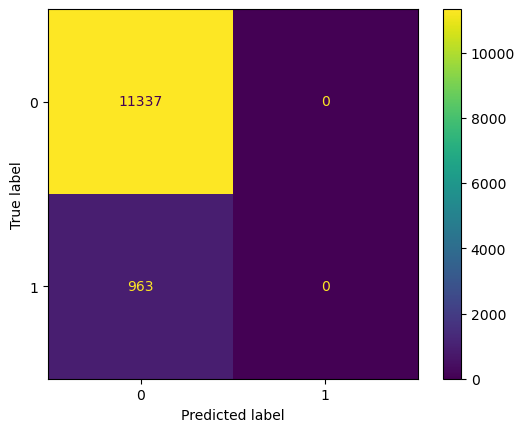

In [22]:
ConfusionMatrixDisplay(confusion_matrix(y_test,dc_pred)).plot()

In [23]:
print_score(y_test, dc_pred)

Accuracy score = 0.9217073170731708
Precision score = 0.0
Recall score = 0.0
F1 score = 0.0
ROC AUC score = 0.5


## 3.5 Log MLFlow

In [24]:
params={}

In [25]:
metrics={"accuracy": accuracy_score(y_test, dc_pred), "ROC AUC": roc_auc_score(y_test, dc_pred)}

In [49]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metrics(metrics)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "DummyClassifier for credit default")

    # Infer the model signature
    signature = infer_signature(X_train, dc.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=dc,
        artifact_path="pret_a_depenser",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-dummy_classifier",
    )


C:\Users\xavie\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
C:\Users\xavie\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'tracking-dummy_classifier'.
2024/02/0

# 4 Autres modèles et pipeline

Pour le pipeline:
- sampler: RandomUnderSampler() (imblearn) 
- transformer: OHE pour cat_feat / log pour feat AMT
- imputer: SimpleImputer('median')
- scaler: StandardScaler()
- estimator = DummyClassifier(), LogReg(), RF(),LightGBM, XGBoost

#### Transformer

In [26]:
log_fct = FunctionTransformer(np.log1p)

In [27]:
transformer= ColumnTransformer(transformers=
                               [
                               ('OneHot',OneHotEncoder(sparse=False,handle_unknown='ignore'),cat_feat),
                               ('num',log_fct,['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY'])                            
                               ],
                               remainder='passthrough'
                             )
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
                                  'NAME_EDUCATION_TYPE']),
                                ('num',
                                 FunctionTransformer(func=<ufunc 'log1p'>),
                                 ['AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                  'AMT_ANNUITY'])])

#### Pipeline

In [28]:
pipeline=Pipeline_imb([
    ('sampler',RandomUnderSampler()),
    ('transformer',transformer),
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),    
    ('estimator',LogisticRegression())
])
pipeline

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['NAME_INCOME_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_EDUCATION_TYPE']),
                                                 ('num',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT',
                                                   'AMT_ANNUITY'])])),
                ('imputer', SimpleImputer()), ('scal

#### Paramgrid

- Avec ou sans scaler
- Avec ou sans sampler (ici RandomUnderSampler() car reste plus de 20000 individus de chaque catégorie (A essayer avec d'autres techniques: SMOTE, oversmapling, class_weight...)
- différents estimateurs: LogisticRegression, RandomForest, XGBoost, LightGBM

In [29]:
param_grid={
    'sampler':[RandomUnderSampler(), 'passthrough'],
    'scaler':[StandardScaler(),'passthrough'],    
    'estimator':[LogisticRegression(),RandomForestClassifier(),LGBMClassifier(),XGBClassifier()]
}

#### GridsearchCV

gridsearch sur 5 folds...

In [30]:
grid= GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=('roc_auc','accuracy','f1','recall','precision'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [31]:
if DISPLAY:
    grid.fit(X,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [32]:
if DISPLAY:
    res=result(grid, log_target=1)
    res.sort_values(by='mean_test_roc_auc',ascending=False).head(5)

In [33]:
RES=pd.DataFrame()

In [34]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)

In [35]:
RES

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,log_target,transf_feat,features
0,0.21,0.03,0.14,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,1,0.74,0.0,0.68,0.00,11,0.68,0.00,0.25,0.01,2,0.26,0.00,0.67,0.02,4,0.67,0.00,0.16,0.00,10,0.16,0.00,1,0,
1,0.29,0.05,0.16,0.03,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,2,0.74,0.0,0.68,0.01,9,0.68,0.00,0.25,0.01,1,0.25,0.00,0.67,0.02,2,0.67,0.00,0.16,0.00,9,0.16,0.00,1,0,
2,0.75,0.06,0.14,0.01,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,3,0.74,0.0,0.92,0.00,4,0.92,0.00,0.02,0.01,13,0.02,0.00,0.01,0.00,13,0.01,0.00,0.42,0.07,5,0.44,0.02,1,0,
3,1.56,0.15,0.12,0.00,LogisticRegression(),passthrough,passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,4,0.74,0.0,0.92,0.00,5,0.92,0.00,0.01,0.00,14,0.02,0.00,0.01,0.00,14,0.01,0.00,0.42,0.05,4,0.42,0.02,1,0,
4,2.58,0.18,0.81,0.03,RandomForestClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': RandomForestClassifier(), 'sampl...",0.73,0.01,9,0.98,0.0,0.68,0.01,10,0.73,0.01,0.25,0.00,4,0.38,0.01,0.66,0.02,6,1.00,0.00,0.15,0.00,11,0.23,0.00,1,0,
5,2.40,0.14,0.81,0.02,RandomForestClassifier(),RandomUnderSampler(),passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.01,12,0.98,0.0,0.68,0.01,12,0.73,0.00,0.25,0.01,6,0.38,0.00,0.65,0.01,7,1.00,0.00,0.15,0.00,14,0.23,0.00,1,0,
6,16.70,0.62,1.06,0.15,RandomForestClassifier(),passthrough,StandardScaler(),"{'estimator': RandomForestClassifier(), 'sampl...",0.71,0.01,16,1.00,0.0,0.92,0.00,3,1.00,0.00,0.01,0.00,16,1.00,0.00,0.01,0.00,16,1.00,0.00,0.38,0.09,8,1.00,0.00,1,0,
7,16.56,1.11,1.04,0.08,RandomForestClassifier(),passthrough,passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.71,0.01,15,1.00,0.0,0.92,0.00,1,1.00,0.00,0.01,0.00,15,1.00,0.00,0.01,0.00,15,1.00,0.00,0.46,0.11,1,1.00,0.00,1,0,
8,8.14,1.13,0.24,0.03,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.01,8,0.83,0.0,0.67,0.01,14,0.69,0.01,0.25,0.00,3,0.30,0.00,0.68,0.02,1,0.81,0.01,0.15,0.00,12,0.18,0.00,1,0,
9,15.54,5.20,0.21,0.02,LGBMClassifier(),RandomUnderSampler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.01,7,0.83,0.0,0.67,0.01,13,0.69,0.01,0.25,0.01,5,0.30,0.00,0.67,0.01,3,0.81,0.01,0.15,0.00,13,0.18,0.00,1,0,


#### Log Mlflow

In [47]:
log_results(grid, experiment_name='credit_default_learning',model_name='1st try',log_only_best=True)

TypeError: log_results() got an unexpected keyword argument 'log_only_best'

#### Même chose sans log

In [33]:
transformer2=ColumnTransformer(transformers=
                               [
                               ('OneHot',OneHotEncoder(sparse=False,handle_unknown='ignore'),cat_feat),
                               ],
                               remainder='passthrough'
                             )
transformer2

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
                                  'NAME_EDUCATION_TYPE'])])

In [34]:
pipeline2=Pipeline_imb([
    ('sampler',RandomUnderSampler(replacement=True)),
    ('transformer',transformer2),
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),
    ('estimator',LogisticRegression())
])
pipeline2

Pipeline(steps=[('sampler', RandomUnderSampler(replacement=True)),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['NAME_INCOME_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_EDUCATION_TYPE'])])),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('estimator', LogisticRegression())])

In [35]:
grid2= GridSearchCV(
    pipeline2,
    param_grid=param_grid,
    cv=5,
    scoring=('roc_auc','accuracy','f1','recall','precision'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [36]:
if DISPLAY:
    grid2.fit(X,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [37]:
res=result(grid2, log_target=0)
res.sort_values(by='mean_test_roc_auc',ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,log_target,transf_feat,features
0,0.11,0.01,0.10,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,1,0.74,0.0,0.68,0.01,9,0.68,0.00,0.25,0.00,1,0.25,0.00,0.67,0.01,3,0.67,0.01,0.16,0.00,8,0.16,0.00,0,0,
2,0.66,0.12,0.12,0.01,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,2,0.74,0.0,0.92,0.00,5,0.92,0.00,0.01,0.00,13,0.01,0.00,0.01,0.00,13,0.01,0.00,0.41,0.03,6,0.42,0.03,0,0,
8,16.61,1.00,0.14,0.02,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.01,5,0.83,0.0,0.67,0.00,12,0.69,0.00,0.25,0.00,2,0.30,0.00,0.67,0.02,2,0.81,0.01,0.15,0.00,9,0.18,0.00,0,0,
9,6.93,4.34,0.15,0.03,LGBMClassifier(),RandomUnderSampler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.01,6,0.83,0.0,0.66,0.01,13,0.69,0.01,0.25,0.00,3,0.30,0.00,0.67,0.01,1,0.82,0.01,0.15,0.00,12,0.18,0.00,0,0,
10,6.89,1.16,0.14,0.02,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.73,0.01,4,0.86,0.0,0.92,0.00,6,0.92,0.00,0.02,0.01,12,0.07,0.01,0.01,0.00,12,0.03,0.00,0.39,0.06,7,0.93,0.01,0,0,


In [38]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,log_target,transf_feat,features
0,0.19,0.01,0.13,0.00,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,1,0.74,0.0,0.68,0.01,9,0.68,0.00,0.25,0.00,1,0.25,0.00,0.67,0.01,4,0.67,0.01,0.16,0.00,9,0.16,0.00,1,0,
1,0.27,0.04,0.13,0.01,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,2,0.74,0.0,0.68,0.01,10,0.68,0.00,0.25,0.00,2,0.25,0.00,0.67,0.02,2,0.67,0.00,0.16,0.00,10,0.16,0.00,1,0,
2,0.65,0.06,0.13,0.02,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,4,0.74,0.0,0.92,0.00,6,0.92,0.00,0.01,0.00,14,0.01,0.00,0.01,0.00,14,0.01,0.00,0.40,0.03,8,0.44,0.02,1,0,
3,1.39,0.13,0.10,0.01,LogisticRegression(),passthrough,passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,3,0.74,0.0,0.92,0.00,4,0.92,0.00,0.01,0.00,13,0.01,0.00,0.01,0.00,13,0.01,0.00,0.42,0.05,7,0.44,0.03,1,0,
4,1.85,0.04,0.62,0.02,RandomForestClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.01,12,0.98,0.0,0.67,0.01,12,0.73,0.01,0.24,0.00,6,0.37,0.01,0.65,0.01,8,1.00,0.00,0.15,0.00,14,0.23,0.00,1,0,
5,1.76,0.01,0.64,0.03,RandomForestClassifier(),RandomUnderSampler(),passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.01,9,0.98,0.0,0.68,0.00,11,0.73,0.00,0.25,0.00,3,0.37,0.00,0.66,0.01,5,1.00,0.00,0.15,0.00,11,0.23,0.00,1,0,
6,11.46,0.16,0.68,0.03,RandomForestClassifier(),passthrough,StandardScaler(),"{'estimator': RandomForestClassifier(), 'sampl...",0.70,0.01,15,1.00,0.0,0.92,0.00,2,1.00,0.00,0.01,0.00,16,1.00,0.00,0.01,0.00,16,1.00,0.00,0.50,0.13,2,1.00,0.00,1,0,
7,10.79,0.48,0.68,0.05,RandomForestClassifier(),passthrough,passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.70,0.01,16,1.00,0.0,0.92,0.00,3,1.00,0.00,0.01,0.00,15,1.00,0.00,0.01,0.00,15,1.00,0.00,0.46,0.07,4,1.00,0.00,1,0,
8,17.03,0.80,0.14,0.02,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.01,7,0.83,0.0,0.67,0.00,14,0.69,0.00,0.25,0.00,4,0.30,0.00,0.67,0.01,1,0.82,0.00,0.15,0.00,12,0.18,0.00,1,0,
9,7.29,4.29,0.14,0.02,LGBMClassifier(),RandomUnderSampler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.01,8,0.83,0.0,0.67,0.01,13,0.69,0.01,0.25,0.00,5,0.30,0.00,0.67,0.02,3,0.82,0.01,0.15,0.00,13,0.18,0.00,1,0,


In [39]:
grid.best_params_

{'estimator': LogisticRegression(),
 'sampler': RandomUnderSampler(),
 'scaler': StandardScaler()}

#### MLflow

In [40]:
#mlflow.set_experiment('credit_default_learning')
#mlflow.end_run()

In [97]:
log_results(grid2,experiment_name='credit_default_learning',model_name='P7_sans_log_V0')

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/83c4f691adc04889b150162082bb6a7e/artifacts
runID: 83c4f691adc04889b150162082bb6a7e
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/d574423b58254e8881793e9a6b7417c8/artifacts
runID: d574423b58254e8881793e9a6b7417c8
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/b4f996c1de744d4bb55c87503e6e57a1/artifacts
runID: b4f996c1de744d4bb55c87503e6e57a1
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/4d08df50d60643c

#### Remplaçons certaines variables par leur booléen (Income type et Family status)

In [104]:
train_V1.columns.to_list()

['SK_ID_CURR',
 'TARGET',
 'FLAG_OWN_CAR',
 'OWN_CAR_AGE',
 'FLAG_OWN_REALTY',
 'NAME_HOUSING_TYPE',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_EDUCATION_TYPE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'client_age',
 'client_prof_exp',
 'Cash_loans',
 'GENDER_FEMALE',
 'active_client',
 'relationship']

In [105]:
X=train_V1.drop(['SK_ID_CURR','TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS'],axis=1)
X.shape

(61498, 16)

In [106]:
y.shape

(61498,)

In [107]:
cat_feat=X.select_dtypes(include=object).columns.to_list()
cat_feat

['NAME_EDUCATION_TYPE']

In [108]:
num_feat

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'client_age',
 'client_prof_exp',
 'Cash_loans',
 'GENDER_FEMALE']

In [109]:
cat_feat=X.select_dtypes(include=object).columns.to_list()
cat_feat

['NAME_EDUCATION_TYPE']

#### avec passage au log (transformer)

In [110]:
transformer= ColumnTransformer(transformers=
                               [
                               ('OneHot',OneHotEncoder(sparse=False,handle_unknown='ignore'),cat_feat),
                               ('num',log_fct,['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY'])
                               ],
                               remainder='passthrough'
                             )
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['NAME_EDUCATION_TYPE']),
                                ('num',
                                 FunctionTransformer(func=<ufunc 'log1p'>),
                                 ['AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                  'AMT_ANNUITY'])])

In [111]:
pipeline=Pipeline_imb([
    ('sampler',RandomUnderSampler(replacement=True)),
    ('transformer',transformer),
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),
    ('estimator',DummyClassifier())
])
pipeline

Pipeline(steps=[('sampler', RandomUnderSampler(replacement=True)),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['NAME_EDUCATION_TYPE']),
                                                 ('num',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT',
                                                   'AMT_ANNUITY'])])),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('estimator', DummyClassifier())])

In [112]:
grid= GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=('roc_auc','accuracy','f1','recall','precision'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [113]:
if DISPLAY:
    grid.fit(X,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [114]:
res=result(grid, log_target=1)
res.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,log_target,transf_feat,features
0,0.13,0.00,0.12,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,1,0.74,0.0,0.68,0.00,10,0.68,0.00,0.25,0.01,1,0.25,0.00,0.67,0.02,2,0.67,0.00,0.16,0.00,9,0.16,0.00,1,0,
1,0.29,0.01,0.12,0.01,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,2,0.74,0.0,0.68,0.01,9,0.68,0.00,0.25,0.01,2,0.25,0.00,0.66,0.02,4,0.67,0.00,0.16,0.00,10,0.16,0.00,1,0,
2,0.45,0.07,0.11,0.01,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,4,0.74,0.0,0.92,0.00,5,0.92,0.00,0.01,0.00,15,0.01,0.00,0.01,0.00,15,0.01,0.00,0.39,0.05,8,0.42,0.01,1,0,
3,1.21,0.11,0.09,0.01,LogisticRegression(),passthrough,passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,3,0.74,0.0,0.92,0.00,3,0.92,0.00,0.01,0.00,14,0.01,0.00,0.01,0.00,14,0.01,0.00,0.42,0.03,4,0.43,0.01,1,0,
8,12.25,9.10,0.20,0.04,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.01,7,0.82,0.0,0.66,0.01,14,0.69,0.00,0.25,0.00,3,0.30,0.00,0.68,0.01,1,0.81,0.01,0.15,0.00,11,0.18,0.00,1,0,
9,18.60,6.72,0.15,0.05,LGBMClassifier(),RandomUnderSampler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.01,8,0.82,0.0,0.67,0.01,13,0.69,0.01,0.25,0.00,4,0.30,0.00,0.67,0.01,3,0.81,0.00,0.15,0.00,13,0.18,0.00,1,0,
10,6.59,0.30,0.14,0.03,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.73,0.01,5,0.86,0.0,0.92,0.00,6,0.92,0.00,0.02,0.00,11,0.06,0.01,0.01,0.00,11,0.03,0.00,0.43,0.07,3,0.91,0.01,1,0,
11,7.24,1.07,0.12,0.00,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.73,0.01,6,0.86,0.0,0.92,0.00,4,0.92,0.00,0.02,0.00,12,0.07,0.01,0.01,0.00,12,0.03,0.00,0.45,0.06,2,0.93,0.02,1,0,
4,2.73,0.08,0.84,0.03,RandomForestClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.00,9,0.98,0.0,0.67,0.01,11,0.72,0.00,0.25,0.00,5,0.37,0.00,0.66,0.02,5,1.00,0.00,0.15,0.00,12,0.23,0.00,1,0,
5,2.68,0.08,0.85,0.03,RandomForestClassifier(),RandomUnderSampler(),passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.01,10,0.98,0.0,0.67,0.00,12,0.72,0.00,0.24,0.00,6,0.37,0.00,0.65,0.01,8,1.00,0.00,0.15,0.00,14,0.23,0.00,1,0,


In [115]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)

In [116]:
RES.sort_values(by='mean_test_roc_auc',ascending=False).head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,log_target,transf_feat,features
0,0.19,0.01,0.13,0.00,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,1,0.74,0.0,0.68,0.01,9,0.68,0.00,0.25,0.00,1,0.25,0.00,0.67,0.01,4,0.67,0.01,0.16,0.00,9,0.16,0.00,1,0,
16,0.11,0.01,0.10,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,1,0.74,0.0,0.68,0.01,9,0.68,0.00,0.25,0.00,1,0.25,0.00,0.67,0.01,3,0.67,0.01,0.16,0.00,8,0.16,0.00,0,0,
32,0.13,0.00,0.12,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,1,0.74,0.0,0.68,0.00,10,0.68,0.00,0.25,0.01,1,0.25,0.00,0.67,0.02,2,0.67,0.00,0.16,0.00,9,0.16,0.00,1,0,
43,7.24,1.07,0.12,0.00,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.73,0.01,6,0.86,0.0,0.92,0.00,4,0.92,0.00,0.02,0.00,12,0.07,0.01,0.01,0.00,12,0.03,0.00,0.45,0.06,2,0.93,0.02,1,0,
42,6.59,0.30,0.14,0.03,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.73,0.01,5,0.86,0.0,0.92,0.00,6,0.92,0.00,0.02,0.00,11,0.06,0.01,0.01,0.00,11,0.03,0.00,0.43,0.07,3,0.91,0.01,1,0,
41,18.60,6.72,0.15,0.05,LGBMClassifier(),RandomUnderSampler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.01,8,0.82,0.0,0.67,0.01,13,0.69,0.01,0.25,0.00,4,0.30,0.00,0.67,0.01,3,0.81,0.00,0.15,0.00,13,0.18,0.00,1,0,
40,12.25,9.10,0.20,0.04,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.01,7,0.82,0.0,0.66,0.01,14,0.69,0.00,0.25,0.00,3,0.30,0.00,0.68,0.01,1,0.81,0.01,0.15,0.00,11,0.18,0.00,1,0,
35,1.21,0.11,0.09,0.01,LogisticRegression(),passthrough,passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,3,0.74,0.0,0.92,0.00,3,0.92,0.00,0.01,0.00,14,0.01,0.00,0.01,0.00,14,0.01,0.00,0.42,0.03,4,0.43,0.01,1,0,
34,0.45,0.07,0.11,0.01,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,4,0.74,0.0,0.92,0.00,5,0.92,0.00,0.01,0.00,15,0.01,0.00,0.01,0.00,15,0.01,0.00,0.39,0.05,8,0.42,0.01,1,0,
33,0.29,0.01,0.12,0.01,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,2,0.74,0.0,0.68,0.01,9,0.68,0.00,0.25,0.01,2,0.25,0.00,0.66,0.02,4,0.67,0.00,0.16,0.00,10,0.16,0.00,1,0,


#### MLflow

In [117]:
log_results(grid,experiment_name='credit_default_learning',model_name='P7_bool_with_log_V0')

Logging parameters
Logging metrics
Logging model


Successfully registered model 'P7_bool_with_log_V0'.
2024/02/05 09:41:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 1
Created version '1' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/b632d10802d64f73bbeff34314fb6ca3/artifacts
runID: b632d10802d64f73bbeff34314fb6ca3
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 2
Created version '2' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/3e3a9e63eb6f48b0ac2190151ca22f00/artifacts
runID: 3e3a9e63eb6f48b0ac2190151ca22f00
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 3
Created version '3' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/7db6d3329c774985ae758025af98b436/artifacts
runID: 7db6d3329c774985ae758025af98b436
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 4
Created version '4' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/24279f4710824765a66185d11322148e/artifacts
runID: 24279f4710824765a66185d11322148e
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 5
Created version '5' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/02593d7353e44b6082d471baa36af10e/artifacts
runID: 02593d7353e44b6082d471baa36af10e
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 6
Created version '6' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/cd1e9994d9d147aaa4bd360707b87f83/artifacts
runID: cd1e9994d9d147aaa4bd360707b87f83
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 7
Created version '7' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/cf72f2f32a184a5db2a4ba15a3f3cf7f/artifacts
runID: cf72f2f32a184a5db2a4ba15a3f3cf7f
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 8
Created version '8' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/78309e93fbe54abb9c165bfb6bb5f1f4/artifacts
runID: 78309e93fbe54abb9c165bfb6bb5f1f4
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 9
Created version '9' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/27d6ffc9a4634095a26911b3ab44311a/artifacts
runID: 27d6ffc9a4634095a26911b3ab44311a
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 10
Created version '10' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/0cd0ca4cbc314ecaa853ece659776802/artifacts
runID: 0cd0ca4cbc314ecaa853ece659776802
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 11
Created version '11' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/21b2a7b563cd4668a8b660ad99d3c3f6/artifacts
runID: 21b2a7b563cd4668a8b660ad99d3c3f6
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 12
Created version '12' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/5e0ffa94cd9c41f1b89e3923ac2f916c/artifacts
runID: 5e0ffa94cd9c41f1b89e3923ac2f916c
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 13
Created version '13' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/6484b80342ce4042a672a1a57fd67002/artifacts
runID: 6484b80342ce4042a672a1a57fd67002
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 14
Created version '14' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/cc2e41f5431e4f6ab57ea925c3bfa9aa/artifacts
runID: cc2e41f5431e4f6ab57ea925c3bfa9aa
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 15
Created version '15' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/35a1d100e9e34c47aadf52bc9bdc00d3/artifacts
runID: 35a1d100e9e34c47aadf52bc9bdc00d3
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_with_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:41:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_with_log_V0, version 16
Created version '16' of model 'P7_bool_with_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/bd1a7d3df2884673850631bd2f4bf418/artifacts
runID: bd1a7d3df2884673850631bd2f4bf418


#### sans passage au log (transformer2)

In [118]:
transformer2=ColumnTransformer(transformers=
                               [
                               ('OneHot',OneHotEncoder(sparse=False,handle_unknown='ignore'),cat_feat),
                               ],
                               remainder='passthrough'
                             )
transformer2

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['NAME_EDUCATION_TYPE'])])

In [119]:
pipeline2=Pipeline_imb([
    ('sampler',RandomUnderSampler(replacement=True)),
    ('transformer',transformer2),
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),
    ('estimator',DummyClassifier())
])
pipeline2

Pipeline(steps=[('sampler', RandomUnderSampler(replacement=True)),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['NAME_EDUCATION_TYPE'])])),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('estimator', DummyClassifier())])

In [120]:
grid2= GridSearchCV(
    pipeline2,
    param_grid=param_grid,
    cv=5,
    scoring=('roc_auc','accuracy','f1','recall','precision'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [121]:
if DISPLAY:
    grid2.fit(X,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [122]:
res=result(grid2, log_target=0)
res.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,log_target,transf_feat,features
0,0.12,0.01,0.09,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,1,0.74,0.0,0.68,0.01,9,0.68,0.00,0.25,0.00,1,0.25,0.00,0.67,0.01,1,0.67,0.00,0.15,0.00,8,0.16,0.00,0,0,
2,0.42,0.06,0.09,0.00,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,3,0.74,0.0,0.92,0.00,5,0.92,0.00,0.01,0.00,15,0.01,0.00,0.01,0.00,15,0.01,0.00,0.44,0.05,5,0.40,0.01,0,0,
8,8.04,7.60,0.19,0.09,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.01,5,0.83,0.0,0.66,0.01,13,0.69,0.01,0.24,0.01,5,0.30,0.00,0.67,0.02,3,0.81,0.01,0.15,0.00,12,0.18,0.00,0,0,
10,12.82,4.87,0.12,0.01,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.73,0.01,2,0.86,0.0,0.92,0.00,4,0.92,0.00,0.02,0.00,11,0.06,0.00,0.01,0.00,11,0.03,0.00,0.48,0.11,2,0.91,0.01,0,0,
11,8.25,3.58,0.12,0.01,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.73,0.01,4,0.86,0.0,0.92,0.00,6,0.92,0.00,0.02,0.00,12,0.07,0.01,0.01,0.00,12,0.03,0.00,0.45,0.06,4,0.93,0.01,0,0,
4,2.63,0.04,0.81,0.02,RandomForestClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.01,7,0.98,0.0,0.67,0.00,11,0.73,0.00,0.24,0.00,3,0.37,0.00,0.65,0.01,5,1.00,0.00,0.15,0.00,10,0.23,0.00,0,0,
5,2.56,0.12,0.82,0.03,RandomForestClassifier(),RandomUnderSampler(),passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.01,8,0.98,0.0,0.67,0.00,10,0.73,0.00,0.24,0.00,4,0.37,0.00,0.65,0.01,6,1.00,0.00,0.15,0.00,11,0.23,0.00,0,0,
9,18.21,7.47,0.17,0.06,LGBMClassifier(),RandomUnderSampler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.72,0.01,6,0.82,0.0,0.67,0.01,12,0.69,0.01,0.25,0.01,2,0.30,0.00,0.67,0.01,2,0.81,0.01,0.15,0.00,9,0.18,0.00,0,0,
14,13.17,0.16,0.12,0.01,"XGBClassifier(base_score=None, booster=None, c...",passthrough,StandardScaler(),"{'estimator': XGBClassifier(base_score=None, b...",0.72,0.01,10,0.91,0.0,0.92,0.00,7,0.93,0.00,0.06,0.02,9,0.24,0.01,0.03,0.01,9,0.13,0.01,0.41,0.09,6,0.97,0.01,0,0,
15,11.62,1.83,0.12,0.06,"XGBClassifier(base_score=None, booster=None, c...",passthrough,passthrough,"{'estimator': XGBClassifier(base_score=None, b...",0.72,0.01,9,0.91,0.0,0.92,0.00,7,0.93,0.00,0.06,0.02,9,0.24,0.01,0.03,0.01,9,0.13,0.01,0.41,0.09,6,0.97,0.01,0,0,


In [123]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)

#### MLflow

In [124]:
log_results(grid2,experiment_name='credit_default_learning',model_name='P7_bool_sans_log_V0')

Logging parameters
Logging metrics
Logging model


Successfully registered model 'P7_bool_sans_log_V0'.
2024/02/05 09:48:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 1
Created version '1' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/1fb68dfe0c17482cba56a5cd92b1dcb5/artifacts
runID: 1fb68dfe0c17482cba56a5cd92b1dcb5
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 2
Created version '2' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/42ce55ba8e7f45bf9afe0179a3c11ff1/artifacts
runID: 42ce55ba8e7f45bf9afe0179a3c11ff1
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 3
Created version '3' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/303003ee897d4fabb275e94366aec8fa/artifacts
runID: 303003ee897d4fabb275e94366aec8fa
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 4
Created version '4' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/018afcd87f6c4aee9325111984b123be/artifacts
runID: 018afcd87f6c4aee9325111984b123be
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 5
Created version '5' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/f320177cc4764408bea66d51a72c2900/artifacts
runID: f320177cc4764408bea66d51a72c2900
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 6
Created version '6' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/48d76323952f411f9a2110da11126745/artifacts
runID: 48d76323952f411f9a2110da11126745
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 7
Created version '7' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/7c0b4d852ec0483682f801f5b0d718b6/artifacts
runID: 7c0b4d852ec0483682f801f5b0d718b6
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 8
Created version '8' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/474fac8d4c5e46cab66a65c272a5cf75/artifacts
runID: 474fac8d4c5e46cab66a65c272a5cf75
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 9
Created version '9' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/53c21dfcbbe64e1cb4e733e8185a4014/artifacts
runID: 53c21dfcbbe64e1cb4e733e8185a4014
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 10
Created version '10' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/8892a5ff66204f83a3cb5d1b5c6e4860/artifacts
runID: 8892a5ff66204f83a3cb5d1b5c6e4860
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 11
Created version '11' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/07866de6cf5b4354bcc6aacb3f7c4ecc/artifacts
runID: 07866de6cf5b4354bcc6aacb3f7c4ecc
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 12
Created version '12' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/1c3cf39eb34542ed9cb4d8fb3a31c767/artifacts
runID: 1c3cf39eb34542ed9cb4d8fb3a31c767
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 13
Created version '13' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/ac011fd08eed485ea14b237a3fbbf06c/artifacts
runID: ac011fd08eed485ea14b237a3fbbf06c
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 14
Created version '14' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/08da29da228449e7b66a7f8724283cf8/artifacts
runID: 08da29da228449e7b66a7f8724283cf8
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 15
Created version '15' of model 'P7_bool_sans_log_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/d64b5ae2fda74dafb96367943b965f94/artifacts
runID: d64b5ae2fda74dafb96367943b965f94
Logging parameters
Logging metrics
Logging model


Registered model 'P7_bool_sans_log_V0' already exists. Creating a new version of this model...
2024/02/05 09:48:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_bool_sans_log_V0, version 16


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/0d768fb3a37844f9b390c5ad33954b38/artifacts
runID: 0d768fb3a37844f9b390c5ad33954b38


Created version '16' of model 'P7_bool_sans_log_V0'.


#### Sans variable catégorielle

In [125]:
train_V1.columns.to_list()

['SK_ID_CURR',
 'TARGET',
 'FLAG_OWN_CAR',
 'OWN_CAR_AGE',
 'FLAG_OWN_REALTY',
 'NAME_HOUSING_TYPE',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_EDUCATION_TYPE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'client_age',
 'client_prof_exp',
 'Cash_loans',
 'GENDER_FEMALE',
 'active_client',
 'relationship']

In [126]:
X=train_V1.drop(['SK_ID_CURR','TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X.shape

(61498, 15)

In [127]:
cat_feat=X.select_dtypes(include=object).columns.to_list()
cat_feat

[]

In [128]:
transformer3= ColumnTransformer(transformers=
                               [
                               ('num',log_fct,['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY'])
                               ]
                             )
transformer3

ColumnTransformer(transformers=[('num',
                                 FunctionTransformer(func=<ufunc 'log1p'>),
                                 ['AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                  'AMT_ANNUITY'])])

In [129]:
pipeline3=Pipeline_imb([
    ('sampler',RandomUnderSampler(replacement=True)),
    ('transformer',transformer3),
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),
    ('estimator',DummyClassifier())
])
pipeline3

Pipeline(steps=[('sampler', RandomUnderSampler(replacement=True)),
                ('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT',
                                                   'AMT_ANNUITY'])])),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('estimator', DummyClassifier())])

In [130]:
param_grid={
    'sampler':[RandomUnderSampler(replacement=True), 'passthrough'],'transformer':[transformer3,'passthrough'],
    'scaler':[StandardScaler(),'passthrough'], 
    'estimator':[LogisticRegression(),RandomForestClassifier(),LGBMClassifier(),XGBClassifier()]
}

In [131]:
grid3= GridSearchCV(
    pipeline3,
    param_grid=param_grid,
    cv=5,
    scoring=('roc_auc','accuracy','f1','recall','precision'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [132]:
if DISPLAY:
    grid3.fit(X,y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [133]:
res=result(grid3, log_target=0)
res.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,param_transformer,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,log_target,transf_feat,features
23,7.02,1.13,0.09,0.01,LGBMClassifier(),passthrough,passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.73,0.01,4,0.86,0.0,0.92,0.00,10,0.92,0.00,0.02,0.00,22,0.06,0.00,0.01,0.00,22,0.03,0.00,0.43,0.12,4,0.93,0.02,0,0,
1,0.09,0.02,0.06,0.00,LogisticRegression(),RandomUnderSampler(replacement=True),StandardScaler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,1,0.73,0.0,0.68,0.00,17,0.68,0.00,0.25,0.00,1,0.25,0.00,0.67,0.01,2,0.67,0.00,0.16,0.00,8,0.16,0.00,0,0,
21,4.81,0.35,0.08,0.01,LGBMClassifier(),passthrough,StandardScaler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.73,0.01,3,0.86,0.0,0.92,0.00,9,0.92,0.00,0.02,0.00,21,0.06,0.01,0.01,0.00,21,0.03,0.00,0.44,0.06,3,0.93,0.02,0,0,
5,0.34,0.02,0.07,0.01,LogisticRegression(),passthrough,StandardScaler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,2,0.73,0.0,0.92,0.00,8,0.92,0.00,0.01,0.00,25,0.01,0.00,0.01,0.00,25,0.01,0.00,0.41,0.03,5,0.41,0.02,0,0,
9,2.64,0.09,0.90,0.03,RandomForestClassifier(),RandomUnderSampler(replacement=True),StandardScaler(),passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.01,7,0.98,0.0,0.66,0.01,19,0.71,0.00,0.24,0.01,4,0.36,0.00,0.67,0.02,3,1.00,0.00,0.15,0.00,11,0.22,0.00,0,0,
11,2.43,0.11,0.86,0.03,RandomForestClassifier(),RandomUnderSampler(replacement=True),passthrough,passthrough,"{'estimator': RandomForestClassifier(), 'sampl...",0.72,0.01,8,0.98,0.0,0.66,0.00,20,0.71,0.00,0.24,0.00,5,0.36,0.00,0.66,0.01,6,1.00,0.00,0.15,0.00,12,0.22,0.00,0,0,
19,4.14,0.30,0.10,0.01,LGBMClassifier(),RandomUnderSampler(replacement=True),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.72,0.01,6,0.82,0.0,0.66,0.00,18,0.69,0.00,0.24,0.00,3,0.30,0.00,0.67,0.01,4,0.81,0.00,0.15,0.00,9,0.18,0.00,0,0,
17,13.33,4.49,0.11,0.02,LGBMClassifier(),RandomUnderSampler(replacement=True),StandardScaler(),passthrough,"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.72,0.01,5,0.82,0.0,0.66,0.00,21,0.68,0.01,0.24,0.00,2,0.29,0.00,0.68,0.02,1,0.81,0.01,0.15,0.00,10,0.18,0.00,0,0,
29,11.72,0.11,0.08,0.00,"XGBClassifier(base_score=None, booster=None, c...",passthrough,StandardScaler(),passthrough,"{'estimator': XGBClassifier(base_score=None, b...",0.71,0.01,10,0.91,0.0,0.92,0.00,13,0.93,0.00,0.06,0.01,17,0.25,0.01,0.03,0.01,17,0.14,0.01,0.40,0.08,6,0.98,0.00,0,0,
31,9.53,0.33,0.07,0.00,"XGBClassifier(base_score=None, booster=None, c...",passthrough,passthrough,passthrough,"{'estimator': XGBClassifier(base_score=None, b...",0.71,0.01,9,0.91,0.0,0.92,0.00,13,0.93,0.00,0.06,0.01,17,0.25,0.01,0.03,0.01,17,0.14,0.01,0.40,0.08,6,0.98,0.00,0,0,


In [134]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)

In [135]:
RES.sort_values(by='mean_test_roc_auc',ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,log_target,transf_feat,features,param_transformer
0,0.19,0.01,0.13,0.00,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,1,0.74,0.0,0.68,0.01,9,0.68,0.0,0.25,0.00,1,0.25,0.00,0.67,0.01,4,0.67,0.01,0.16,0.00,9,0.16,0.00,1,0,,NaN
32,0.13,0.00,0.12,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,1,0.74,0.0,0.68,0.00,10,0.68,0.0,0.25,0.01,1,0.25,0.00,0.67,0.02,2,0.67,0.00,0.16,0.00,9,0.16,0.00,1,0,,NaN
16,0.11,0.01,0.10,0.01,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.74,0.01,1,0.74,0.0,0.68,0.01,9,0.68,0.0,0.25,0.00,1,0.25,0.00,0.67,0.01,3,0.67,0.01,0.16,0.00,8,0.16,0.00,0,0,,NaN
42,6.59,0.30,0.14,0.03,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.73,0.01,5,0.86,0.0,0.92,0.00,6,0.92,0.0,0.02,0.00,11,0.06,0.01,0.01,0.00,11,0.03,0.00,0.43,0.07,3,0.91,0.01,1,0,,NaN
26,6.89,1.16,0.14,0.02,LGBMClassifier(),passthrough,StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.73,0.01,4,0.86,0.0,0.92,0.00,6,0.92,0.0,0.02,0.01,12,0.07,0.01,0.01,0.00,12,0.03,0.00,0.39,0.06,7,0.93,0.01,0,0,,NaN
27,16.33,4.63,0.11,0.01,LGBMClassifier(),passthrough,passthrough,"{'estimator': LGBMClassifier(), 'sampler': 'pa...",0.73,0.01,3,0.86,0.0,0.92,0.00,4,0.92,0.0,0.02,0.00,11,0.07,0.01,0.01,0.00,11,0.03,0.00,0.48,0.05,2,0.94,0.01,0,0,,NaN
33,0.29,0.01,0.12,0.01,LogisticRegression(),RandomUnderSampler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,2,0.74,0.0,0.68,0.01,9,0.68,0.0,0.25,0.01,2,0.25,0.00,0.66,0.02,4,0.67,0.00,0.16,0.00,10,0.16,0.00,1,0,,NaN
34,0.45,0.07,0.11,0.01,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,4,0.74,0.0,0.92,0.00,5,0.92,0.0,0.01,0.00,15,0.01,0.00,0.01,0.00,15,0.01,0.00,0.39,0.05,8,0.42,0.01,1,0,,NaN
35,1.21,0.11,0.09,0.01,LogisticRegression(),passthrough,passthrough,"{'estimator': LogisticRegression(), 'sampler':...",0.73,0.01,3,0.74,0.0,0.92,0.00,3,0.92,0.0,0.01,0.00,14,0.01,0.00,0.01,0.00,14,0.01,0.00,0.42,0.03,4,0.43,0.01,1,0,,NaN
40,12.25,9.10,0.20,0.04,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"{'estimator': LGBMClassifier(), 'sampler': Ran...",0.73,0.01,7,0.82,0.0,0.66,0.01,14,0.69,0.0,0.25,0.00,3,0.30,0.00,0.68,0.01,1,0.81,0.01,0.15,0.00,11,0.18,0.00,1,0,,NaN


In [74]:
RES.to_csv('C:/Users/xavie/P7/RES.csv', index =False)

In [136]:
log_results(grid3,experiment_name='credit_default_learning',model_name='P7_no_cat_feat_V0')

Logging parameters
Logging metrics
Logging model


Successfully registered model 'P7_no_cat_feat_V0'.
2024/02/05 09:52:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 1
Created version '1' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/fc7aae1effa34470ba96690f0a2f0a8a/artifacts
runID: fc7aae1effa34470ba96690f0a2f0a8a
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:52:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 2
Created version '2' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/7db2f485e0bc481bbd91cd4b4264d685/artifacts
runID: 7db2f485e0bc481bbd91cd4b4264d685
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:52:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 3
Created version '3' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/5ca6cd2d89914e4197b19044e7fb45cd/artifacts
runID: 5ca6cd2d89914e4197b19044e7fb45cd
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:52:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 4
Created version '4' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/08f2dc56aa55456faf2df170d22af63c/artifacts
runID: 08f2dc56aa55456faf2df170d22af63c
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:52:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 5
Created version '5' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/bc87f5b878834257b7f63ee1d6b9fb8e/artifacts
runID: bc87f5b878834257b7f63ee1d6b9fb8e
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 6
Created version '6' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/e996bbab391e491591788210a1bc7093/artifacts
runID: e996bbab391e491591788210a1bc7093
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 7
Created version '7' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/9899e06e970c44ee86310daf53e8ce1d/artifacts
runID: 9899e06e970c44ee86310daf53e8ce1d
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 8
Created version '8' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/7af60cc483ad407ab17d9de490a412e6/artifacts
runID: 7af60cc483ad407ab17d9de490a412e6
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 9
Created version '9' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/78f5a5811dd34594acf660390a3b5402/artifacts
runID: 78f5a5811dd34594acf660390a3b5402
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 10
Created version '10' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/99564a3156d84006be98e9b552526a72/artifacts
runID: 99564a3156d84006be98e9b552526a72
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 11
Created version '11' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/94563adbd66c477e9759ee5dc6b8104e/artifacts
runID: 94563adbd66c477e9759ee5dc6b8104e
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 12
Created version '12' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/7d655292dc1e414fb140b408fb6558e5/artifacts
runID: 7d655292dc1e414fb140b408fb6558e5
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 13
Created version '13' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/91cf515649bf4203a7bf9769102f8441/artifacts
runID: 91cf515649bf4203a7bf9769102f8441
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 14
Created version '14' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/22f40b3ddeb04af882fbf4de0791bc7d/artifacts
runID: 22f40b3ddeb04af882fbf4de0791bc7d
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 15
Created version '15' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/35c0479f3cbb40d2b748cdb451838f85/artifacts
runID: 35c0479f3cbb40d2b748cdb451838f85
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 16
Created version '16' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/84032e9aca1a4481b6c4aafa2f81224c/artifacts
runID: 84032e9aca1a4481b6c4aafa2f81224c
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 17
Created version '17' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/39a2fc54b28d4d27a85ca78268dfda86/artifacts
runID: 39a2fc54b28d4d27a85ca78268dfda86
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 18
Created version '18' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/2dca6d95d65a47508dbc2ff820ab21f1/artifacts
runID: 2dca6d95d65a47508dbc2ff820ab21f1
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 19
Created version '19' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/d7b201c516e94f1699bd5ce0726258cf/artifacts
runID: d7b201c516e94f1699bd5ce0726258cf
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 20
Created version '20' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/dc15655e8f1f4141a07d0f151d227740/artifacts
runID: dc15655e8f1f4141a07d0f151d227740
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 21
Created version '21' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/7931e5789c1e40d8b045dc22cc0d11c4/artifacts
runID: 7931e5789c1e40d8b045dc22cc0d11c4
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 22
Created version '22' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/e0db760c17954c85972d51709f6d2499/artifacts
runID: e0db760c17954c85972d51709f6d2499
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 23
Created version '23' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/95450b4d9aa34db4929e68ff2a158f6f/artifacts
runID: 95450b4d9aa34db4929e68ff2a158f6f
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 24
Created version '24' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/57f99451d23d46bcb4addef242d41552/artifacts
runID: 57f99451d23d46bcb4addef242d41552
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 25
Created version '25' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/212eb74e8a954b188ccad223321bf715/artifacts
runID: 212eb74e8a954b188ccad223321bf715
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 26
Created version '26' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/8c2cbeb0f23c401b8f473780021b0425/artifacts
runID: 8c2cbeb0f23c401b8f473780021b0425
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 27
Created version '27' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/aabd27c0c890439a8160af33deb7be27/artifacts
runID: aabd27c0c890439a8160af33deb7be27
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 28
Created version '28' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/41a3930436e4473182665a000c675c9d/artifacts
runID: 41a3930436e4473182665a000c675c9d
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 29
Created version '29' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/c30c8dea0ed34bec8ebff63ad78a2022/artifacts
runID: c30c8dea0ed34bec8ebff63ad78a2022
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 30
Created version '30' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/0f9e28c4a0cd410abeafb0bd80278dbf/artifacts
runID: 0f9e28c4a0cd410abeafb0bd80278dbf
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 31
Created version '31' of model 'P7_no_cat_feat_V0'.


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/397435b9c0384f30a23bc2e861c276a1/artifacts
runID: 397435b9c0384f30a23bc2e861c276a1
Logging parameters
Logging metrics
Logging model


Registered model 'P7_no_cat_feat_V0' already exists. Creating a new version of this model...
2024/02/05 09:53:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: P7_no_cat_feat_V0, version 32


Logging CV results matrix
Logging extra data related to the experiment
file:///C:/Users/xavie/P7/P7_ML_model/mlruns/647401016888085031/6ac62789297840288f5e3ee8fd7b97de/artifacts
runID: 6ac62789297840288f5e3ee8fd7b97de


Created version '32' of model 'P7_no_cat_feat_V0'.


In [137]:
grid3.best_estimator_

Pipeline(steps=[('sampler', RandomUnderSampler(replacement=True)),
                ('transformer', 'passthrough'), ('imputer', SimpleImputer()),
                ('scaler', StandardScaler()),
                ('estimator', LogisticRegression())])

In [138]:
grid3.best_params_

{'estimator': LogisticRegression(),
 'sampler': RandomUnderSampler(replacement=True),
 'scaler': StandardScaler(),
 'transformer': 'passthrough'}

### Conclusion
- résultats meilleurs sans var catégorielles (ie sans passage par OHE) => à revérifier suite à ajout de reamainder = 'passthrough'
- avec scaler
- sans passage au log
- avec sampler (ie avec equilibrage des classes)

=> Partir sur ces bases pour amélioratiosn des hyperparamètres

Essai avec KNNImputer

In [77]:
#pipeline4=Pipeline_imb([
#    ('sampler',RandomUnderSampler(replacement=True)),
#    ('transformer',transformer3),
#    ('imputer',KNNImputer()),
#    ('scaler',StandardScaler()),
#    ('estimator',DummyClassifier())
#])
#pipeline4

In [78]:
#param_grid={
#    'sampler':[RandomUnderSampler(replacement=True), 'passthrough'],
#    'transformer':[transformer3,'passthrough'],
#    'scaler':[StandardScaler(),'passthrough'], 
#    'estimator':[LogisticRegression(),LGBMClassifier(),]
#}

In [79]:
#grid4= GridSearchCV(
#    pipeline4,
#    param_grid=param_grid,
#    cv=5,
#    scoring=('roc_auc','accuracy','f1','recall','precision'),
#    n_jobs=-1,
#    verbose=2,
#    return_train_score=True,
#    refit='roc_auc')

In [80]:
#grid4.fit(X,y)

#### Représentation graphique du meilleur modèle (y_pred vs y_true / matrice de confusion)

In [81]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [82]:
print('Train set:',X_train.shape)
print('Test set:',X_test.shape)
print('Train target:',y_train.shape)
print('Test target:',y_test.shape)

Train set: (49198, 15)
Test set: (12300, 15)
Train target: (49198,)
Test target: (12300,)


#### Best model en V1 = LogReg (bcp + rapide)

In [83]:
best_model=Pipeline_imb([
    ('sampler',RandomUnderSampler()),
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
    ('estimator',LogisticRegression())
])
best_model

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator', LogisticRegression())])

In [84]:
best_model.fit(X_train,y_train)

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator', LogisticRegression())])

In [85]:
lr_predict=best_model.predict(X_test)

In [86]:
print_score(y_test, lr_predict)

Accuracy score = 0.6773170731707318
Precision score = 0.15428966789667897
Recall score = 0.6889804325437693
F1 score = 0.25211984171848506
ROC AUC score = 0.6826489240130797


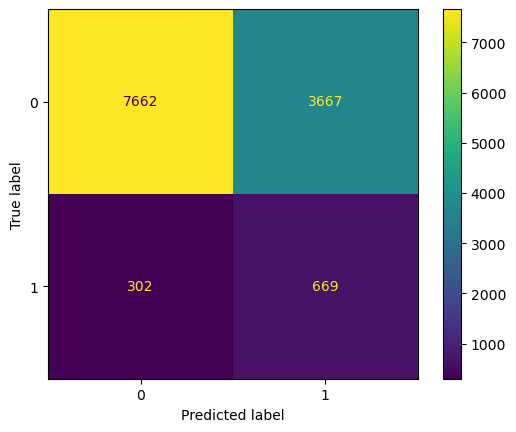

In [87]:
ConfusionMatrixDisplay(confusion_matrix(y_test,lr_predict)).plot()

#### A creuser: AUC ROC = 0.50+ (sans sampler) . Bien loin du résultat de grid3...

AUC ROC = 0.68 avec resampling (LGBM) - 0.65 avec LR suite à revue du code (ajout handle unknown et resampling en début de pipeline)

In [88]:
### Create a Pickle file using serialization for API (cf part 7, done now in order to get right best_model)
import pickle
pickle_out = open("classifier.pkl","wb")
pickle.dump(best_model, pickle_out)
pickle_out.close()

# 5 Feature importance

## Si best.model = LGBM

In [89]:
#best_model.steps

In [90]:
#best_model.steps[3][1].feature_importances_

features_importances_ fonctionne avec LGBM mais pas avec LogReg

In [91]:
#plot_importance(best_model.steps[3][1])

In [92]:
#best_model.get_feature_names_out

In [93]:
#best_model[-1].feature_name_

A ce stade je ne sais pas comment récupérer lmes noms des features donc graphe difficilement lisible

In [94]:
feat=X_train.columns.to_list()
feat

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'client_age',
 'client_prof_exp',
 'Cash_loans',
 'GENDER_FEMALE',
 'active_client',
 'relationship']

#### Reconstruction du dataframe pour affichage des features

In [95]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [96]:
best_model.steps

[('sampler', RandomUnderSampler()),
 ('imputer', SimpleImputer(strategy='median')),
 ('scaler', StandardScaler()),
 ('estimator', LogisticRegression())]

In [97]:
IMP=SimpleImputer(strategy='median')

In [98]:
SCA=StandardScaler()

In [99]:
X_train

,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
26373,0,1,180000.0,170640.0,9657.0,2.0,0.657327,0.540836,0.363945,54,-0.0,1,1,0,1
188204,0,0,171000.0,239850.0,25830.0,1.0,NaN,0.709210,0.773896,23,1.0,1,1,1,0
242883,0,0,112500.0,547344.0,29160.0,2.0,NaN,0.033521,0.350696,50,4.0,1,1,1,1
129109,0,0,135000.0,545040.0,26640.0,1.0,0.466952,0.483552,0.329655,32,7.0,1,0,1,0
135641,0,1,121500.0,172512.0,13477.5,1.0,NaN,0.411474,0.588488,60,-0.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304632,1,1,157500.0,528633.0,39654.0,2.0,NaN,0.401245,0.801601,46,25.0,1,0,1,0
5906,0,1,81000.0,247500.0,12375.0,1.0,NaN,0.065844,0.691021,46,3.0,0,1,1,0
90640,0,1,135000.0,573057.0,35059.5,2.0,NaN,0.679826,NaN,29,1.0,1,0,1,1
192965,1,0,180000.0,1125000.0,46426.5,2.0,0.641854,0.454713,0.220095,33,8.0,1,1,1,1


In [100]:
A=IMP.fit_transform(X_train)
A=SCA.fit_transform(A)
A=pd.DataFrame(A, columns=X_train.columns)
A.shape

(49198, 15)

In [101]:
X_train.shape

(49198, 15)

In [102]:
y_train.shape

(49198,)

#### Sampling manuel

In [103]:
X_train_rus, y_train_rus=RandomUnderSampler().fit_resample(A,y_train)

In [104]:
X_train_rus.shape

(7846, 15)

In [105]:
y_train_rus.shape

(7846,)

Je 'fit' l'estimateur sur les X-train et y_train 'samplés'

In [106]:
EST=LGBMClassifier()
EST

LGBMClassifier()

In [107]:
EST.fit(X_train_rus, y_train_rus)

[LightGBM] [Info] Number of positive: 3923, number of negative: 3923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 7846, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

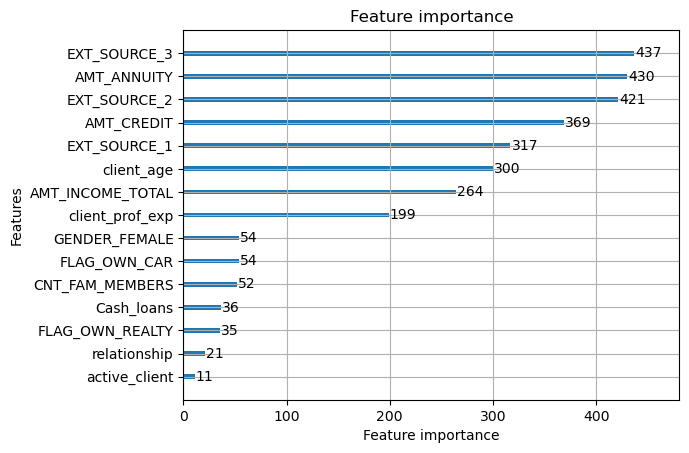

In [108]:
plot_importance(EST)

Je scale X_test...

In [109]:
X_test_sca=IMP.fit_transform(X_test)
X_test_sca=SCA.fit_transform(X_test_sca)
X_test_sca=pd.DataFrame(X_test_sca, columns=X_test.columns)
X_test_sca.shape

(12300, 15)

In [110]:
y_pred=EST.predict(X_test_sca)

In [111]:
y_test.shape

(12300,)

In [112]:
y_pred.shape

(12300,)

In [113]:
print_score(y_test, y_pred)

Accuracy score = 0.6761788617886179
Precision score = 0.15270708005552985
Recall score = 0.672782874617737
F1 score = 0.24891570808976055
ROC AUC score = 0.6746280306475028


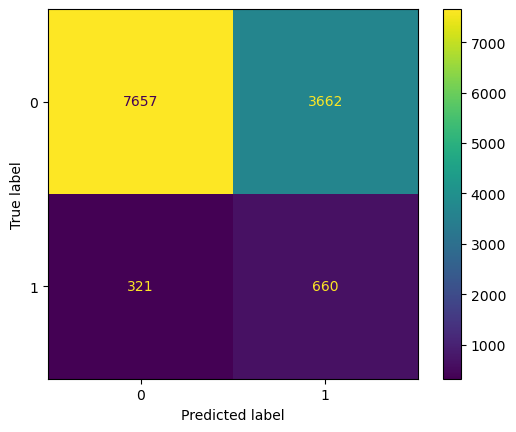

In [114]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

Avec importance_type = gain

In [115]:
EST=LGBMClassifier(importance_type='gain')

In [116]:
EST.fit(X_train_rus, y_train_rus)

[LightGBM] [Info] Number of positive: 3923, number of negative: 3923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 7846, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(importance_type='gain')

In [117]:
EST.importance_type

'gain'

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

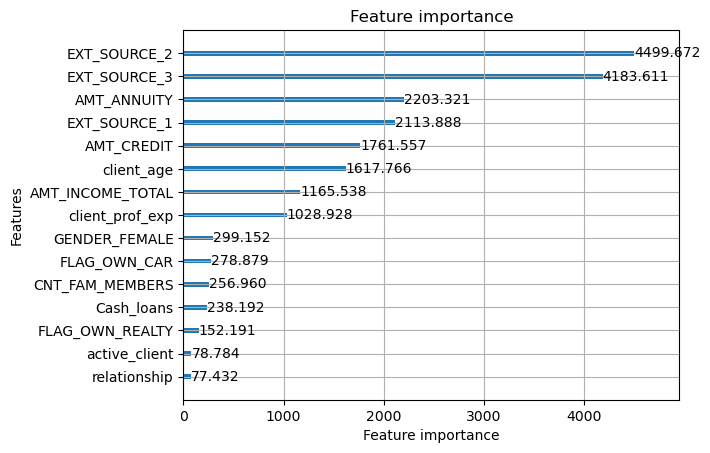

In [118]:
plot_importance(EST)

In [119]:
y_pred=EST.predict(X_test_sca)

In [120]:
print_score(y_test, y_pred)

Accuracy score = 0.6761788617886179
Precision score = 0.15270708005552985
Recall score = 0.672782874617737
F1 score = 0.24891570808976055
ROC AUC score = 0.6746280306475028


## Si best.model = LogReg

- Essai avec bout de code trouvé sur le net

In [121]:
best_model.steps

[('sampler', RandomUnderSampler()),
 ('imputer', SimpleImputer(strategy='median')),
 ('scaler', StandardScaler()),
 ('estimator', LogisticRegression())]

In [122]:
feat_importance=abs(best_model.steps[3][1].coef_[0])
feat_importance = 100.0 * (feat_importance / feat_importance.max())

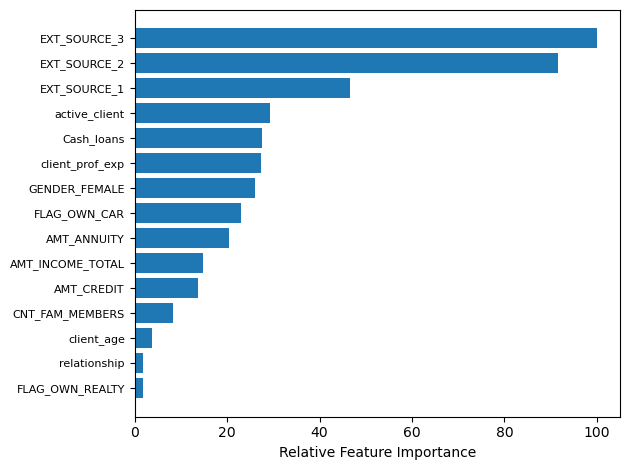

In [123]:
sorted_idx = np.argsort(feat_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feat_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

## 5.3 SHAP

### 5.3.1 Init

In [124]:
#np.version.version

In [125]:
import shap

In [126]:
shap.initjs()

### 5.3.1 Reconstitution du modèle 
- df à entrainer: X_train_rus
- EST = LogReg()

In [127]:
X_train_rus 

,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
6816,1.392272,-1.496561,0.443523,0.185376,-0.034033,-0.168515,-1.701242,0.353447,0.108599,-1.212268,0.255262,0.323389,0.718413,0.469275,0.599781
43679,-0.718250,0.668199,-0.992661,-1.100825,-1.280015,-1.273189,0.014619,-1.323597,0.108599,1.130647,-0.846764,0.323389,-1.391957,-2.130948,-1.667276
31262,-0.718250,0.668199,0.119223,-0.219034,0.043289,-0.168515,0.014619,-0.266647,-0.851594,0.210216,0.255262,0.323389,0.718413,0.469275,0.599781
30438,-0.718250,0.668199,-0.112419,1.655556,1.795212,-0.168515,0.014619,0.277288,-1.294821,0.377567,-0.374467,0.323389,-1.391957,0.469275,0.599781
31140,-0.718250,-1.496561,-0.575705,-0.362181,0.382105,-1.273189,0.014619,0.830524,0.383172,1.214323,-0.846764,0.323389,0.718413,-2.130948,-1.667276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49173,-0.718250,0.668199,1.972365,0.098661,0.182407,2.040834,-1.626228,0.050789,0.221187,-1.044917,-0.059603,0.323389,0.718413,0.469275,0.599781
49175,-0.718250,0.668199,1.045794,1.708479,0.712094,-1.273189,-1.665572,-2.408092,-0.822804,-1.295944,-0.531900,0.323389,0.718413,0.469275,-1.667276
49181,-0.718250,0.668199,-0.112419,-1.178824,-1.402391,-0.168515,-0.243970,0.390494,0.108599,-0.459188,1.357288,0.323389,0.718413,0.469275,0.599781
49190,-0.718250,0.668199,-1.085318,1.191094,0.299913,0.936160,0.014619,-1.307572,-0.128333,-0.208162,-0.217035,0.323389,0.718413,0.469275,0.599781


In [128]:
y_train_rus.shape

(7846,)

In [129]:
EST=LogisticRegression()
EST

LogisticRegression()

### 5.3.2 Summary plot

In [130]:
EST.fit(X_train_rus,y_train_rus)

LogisticRegression()

In [131]:
explainer=shap.LinearExplainer(EST,X_train_rus)
explainer

In [132]:
shap_values=explainer(X_train_rus)

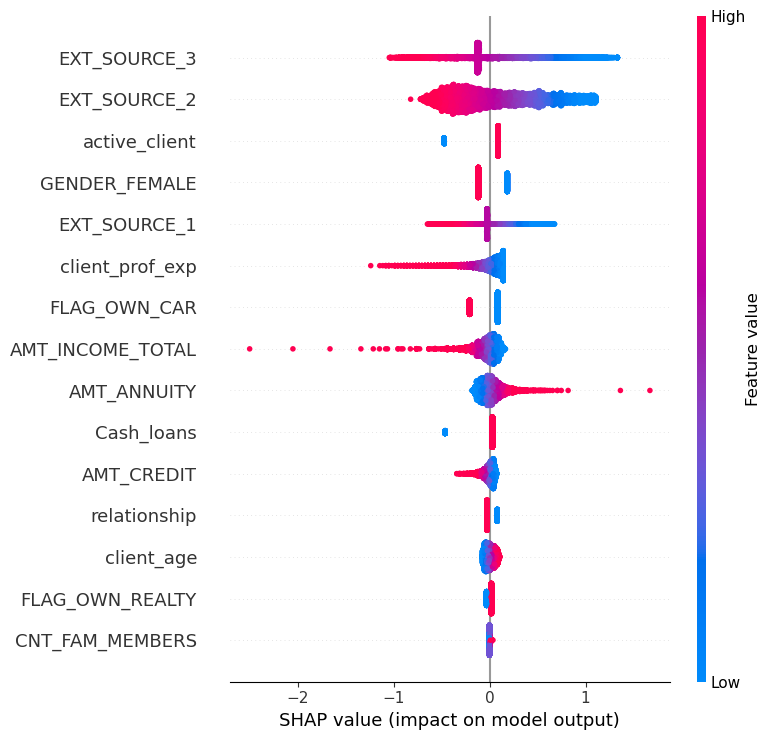

In [133]:
shap.summary_plot(shap_values)

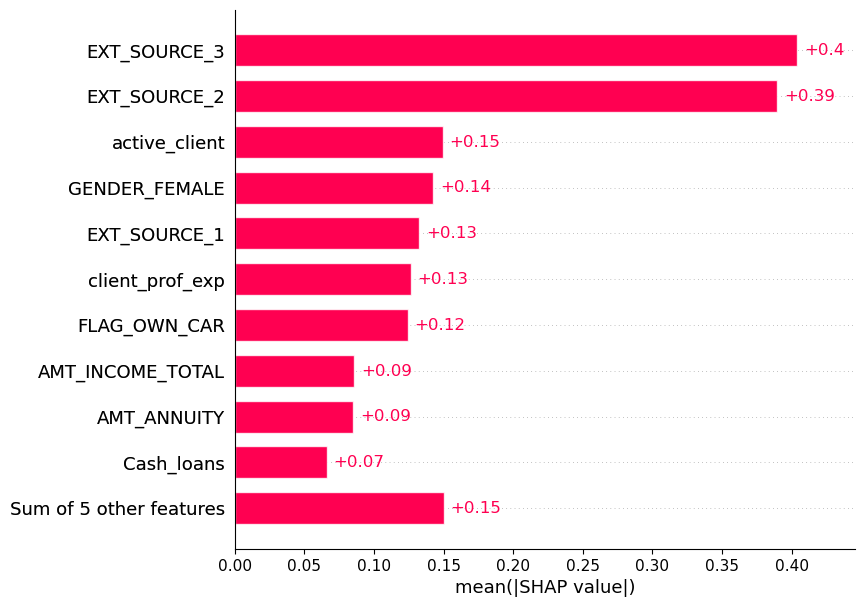

In [134]:
shap.plots.bar(shap_values, max_display= 11)

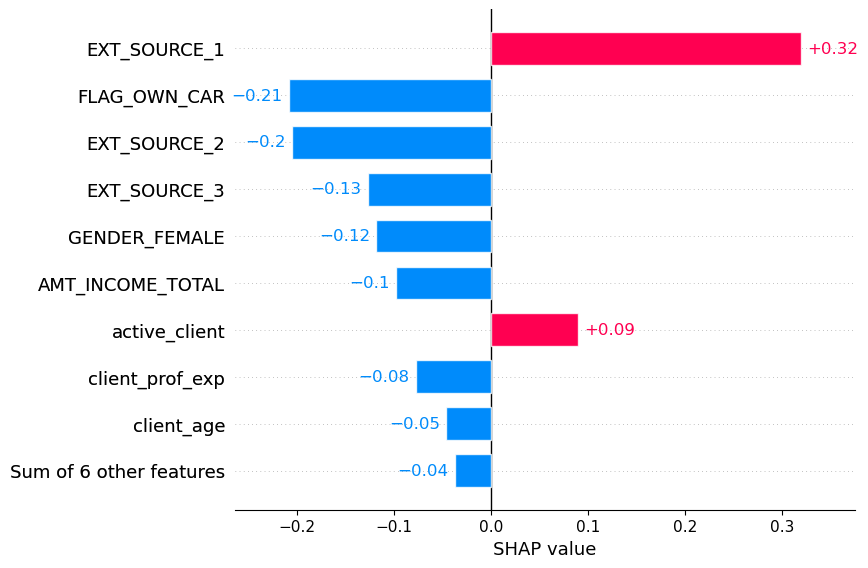

In [135]:
shap.plots.bar(shap_values[0])

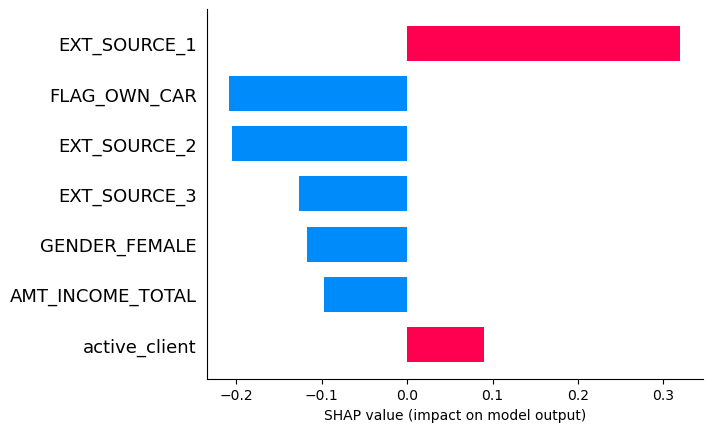

In [136]:
shap.bar_plot(explainer.shap_values(X_train_rus.iloc[0]),
              feature_names=feat,)

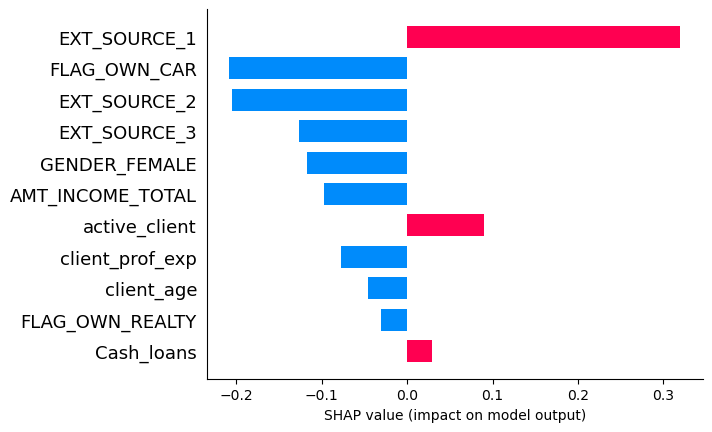

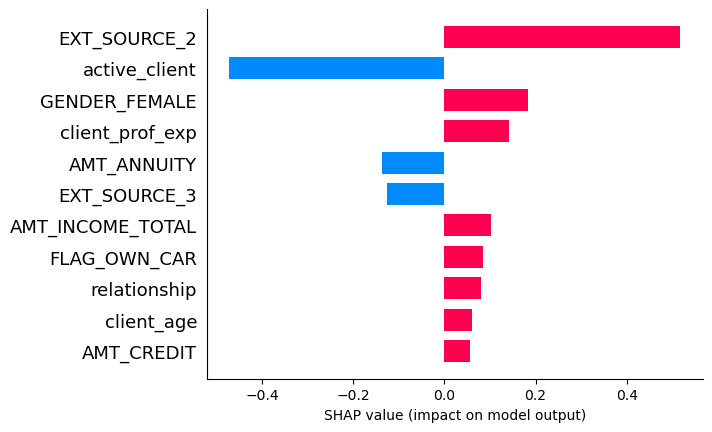

In [137]:
shap.bar_plot(explainer.shap_values(X_train_rus)[0], feature_names=feat, max_display=11)
shap.bar_plot(explainer.shap_values(X_train_rus)[1], feature_names=feat, max_display=11)


In [138]:
X_train_rus.describe()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
count,7846.000000,7846.000000,7846.000000,7846.000000,7846.000000,7846.000000,7846.000000,7846.000000,7846.000000,7846.000000,7846.000000,7846.000000,7846.000000,7846.000000,7846.000000
mean,-0.042001,-0.013289,-0.044264,-0.047019,-0.026437,-0.000406,-0.148109,-0.242727,-0.245141,-0.116264,-0.072685,0.036067,-0.077481,0.065952,-0.036475
std,0.984911,1.005465,0.926202,0.937342,0.926910,1.016170,1.031700,1.083557,1.061608,0.989032,0.917718,0.948129,1.022896,0.941368,1.018694
min,-0.718250,-1.496561,-1.455947,-1.379073,-1.662059,-1.273189,-3.458026,-2.699921,-2.939915,-1.881673,-0.846764,-3.092255,-1.391957,-2.130948,-1.667276
25%,-0.718250,-1.496561,-0.575705,-0.799333,-0.701012,-0.168515,-0.014703,-1.062443,-0.992936,-0.961242,-0.689332,0.323389,-1.391957,0.469275,-1.667276
50%,-0.718250,0.668199,-0.251405,-0.228097,-0.148951,-0.168515,0.014619,0.010474,0.108599,-0.208162,-0.374467,0.323389,0.718413,0.469275,0.599781
75%,1.392272,0.668199,0.350866,0.450886,0.445957,0.936160,0.014619,0.640407,0.403229,0.712270,0.255262,0.323389,0.718413,0.469275,0.599781
max,1.392272,0.668199,17.724067,5.202788,13.375867,8.668880,3.059061,1.787230,2.028979,2.134754,6.080257,0.323389,0.718413,0.469275,0.599781


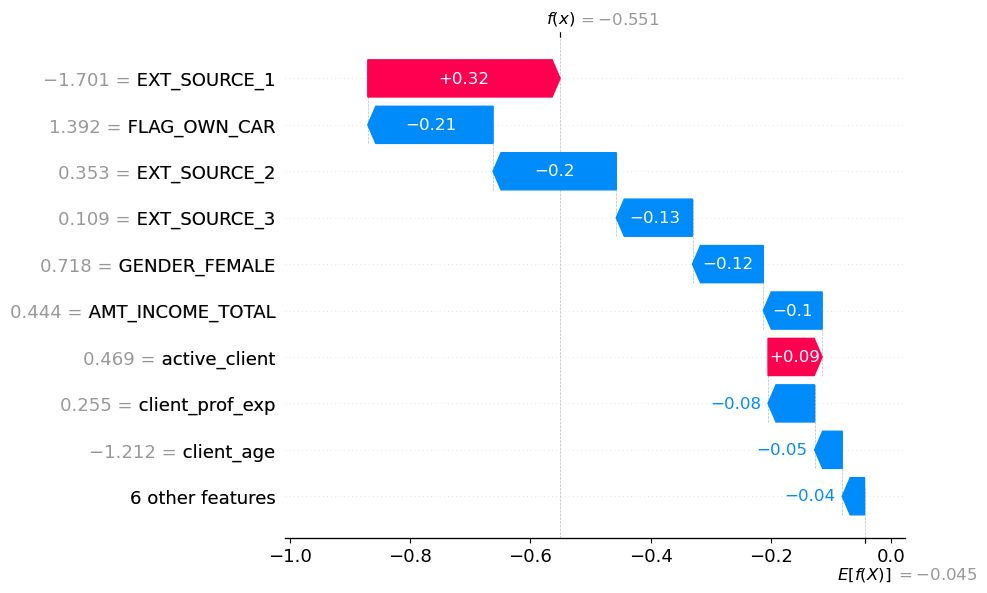

In [139]:
#shap_values.feature_names = feat.tolist()
shap.waterfall_plot(shap_values[0])#, max_display=len(feat))

In [140]:
ev=explainer.expected_value
ev

-0.04462815994962921

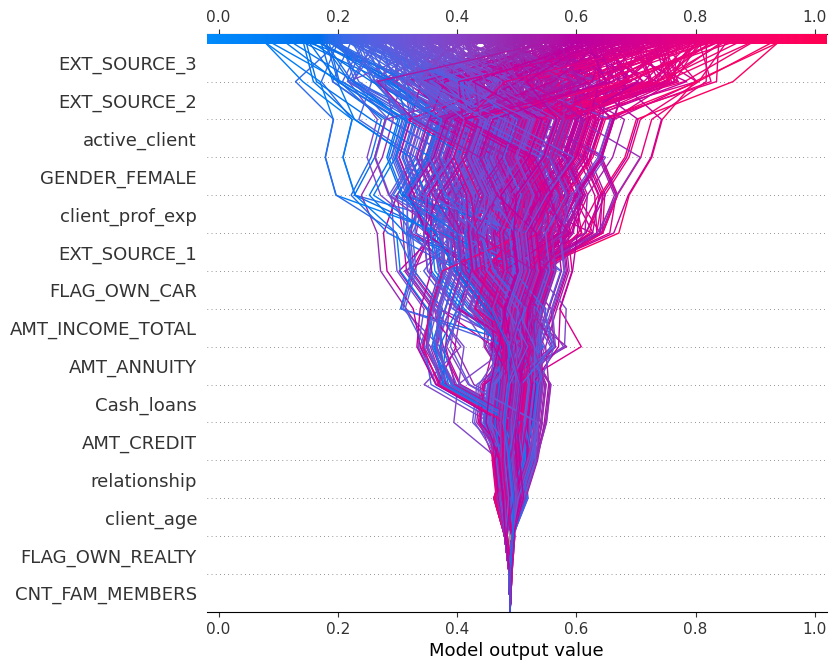

In [141]:
shap.decision_plot(ev,explainer.shap_values(X_train_rus.sample(500)), feat, link="logit",) #features_display

In [142]:
shap.force_plot(explainer.expected_value,
                explainer.shap_values(X_train_rus.iloc[0]),
                feature_names=feat)#,out_names="XXXX")

## 5.4 Essai yellowbrick

In [143]:
from yellowbrick.classifier import DiscriminationThreshold

In [144]:
model= LogisticRegression()
visualizer=DiscriminationThreshold(model)


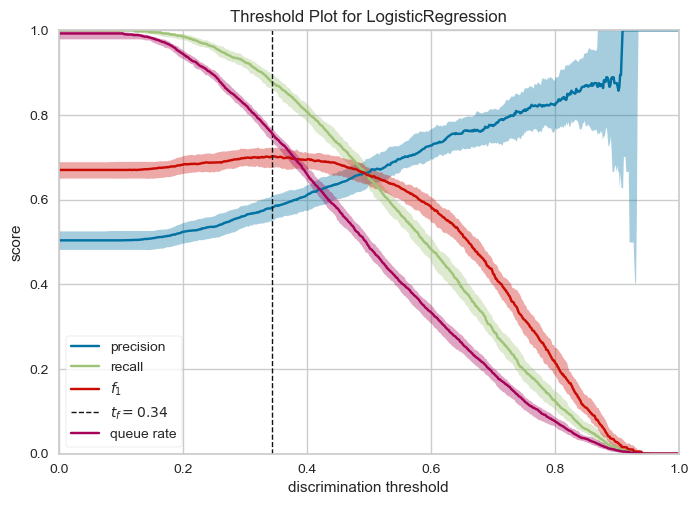

<AxesSubplot:title={'center':'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [145]:
visualizer.fit(X_train_rus,y_train_rus)
visualizer.show()

# 6 Def d'une fonction 'gain' pour estimer l'argent gagné

## 6.1 Fonction permettant d'estimer le différentiel entre prédictions et réalité

### Règles de calcul:
- Si y-pred = y_true = 0 => gain= interêts perçus sur le crédit = M * i * n
    
    M= Montant du crédit ;    
    i = taux d'interêt ;    
    n = nb d'année;
        
    Mais pas de gain par rapport à la situation sans modèle de prédiction
    

- Si y-pred = y_true = 1 => Si on considère que le prêt a été accordé à tort dans la réalité et que grace à notre modèle on n'octroie pas le crédit, le gain est une perte évitée soit:

    Montant du crédit moins revente du produit financé (moisn décôte de 30%) => M-(30% * PP)

- Si y_pred =1 et y_true= 0 => Faux négatif: montant non accordé à tort: Manque à gagner (perte) = M * i * n

- SI y_pred = 0 et y_true =1 => Faux positif: montant accordé à tort: Perte = Montant du crédit - revente du bien acheté (avec décote de 30% par ex) => M-(30% * PP)

Rappel:  les NaN sur AMNT_GOODS_PRICE ont été défaulté avec le montant du crédit associé

### J'ai besoin de AMT_GOODS_PRICE pour le calcul de la fonction gain mais pas pour fit du LGBM. 
Pb lors fit du best_model (pipeline) => comme pour calcul de la feature importance je fais tourner le modèle manuellement.

essai avec drop dans ColumnsTransformer??


In [146]:
train_V1.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,OWN_CAR_AGE,FLAG_OWN_REALTY,NAME_HOUSING_TYPE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
225171,360832,0,0,NaN,1,House / apartment,252000.0,509922.0,26401.5,472500.0,Working,Separated,Higher education,1.0,NaN,0.674957,0.477649,47,2.0,1,1,1,0
20729,124160,0,0,NaN,1,House / apartment,126000.0,942300.0,30528.0,675000.0,Pensioner,Separated,Secondary / secondary special,1.0,NaN,0.119868,0.367291,60,-0.0,1,1,0,0
191982,322634,0,0,NaN,1,House / apartment,180000.0,619965.0,24151.5,517500.0,Working,Married,Higher education,2.0,0.615425,0.478017,0.570917,43,4.0,1,1,1,1
119194,238220,0,1,25.0,0,House / apartment,270000.0,582768.0,54616.5,540000.0,Commercial associate,Married,Higher education,2.0,NaN,0.588430,0.520898,47,3.0,1,0,1,1
60779,170489,0,0,NaN,1,House / apartment,112500.0,500211.0,34942.5,463500.0,Commercial associate,Married,Higher education,2.0,0.584978,0.758451,0.639708,31,0.0,1,1,1,1


Dans X_tmp, j'inclus AMT_GOODS_PRICE

In [147]:
X_tmp=train_V1.drop(['TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X_tmp.shape

(61498, 17)

In [148]:
y.shape

(61498,)

Train test split sur base X_tmp

In [149]:
X_train,X_test,y_train,y_test=train_test_split(X_tmp,y,test_size=0.2)

In [150]:
print('Train set:',X_train.shape)
print('Test set:',X_test.shape)
print('Train target:',y_train.shape)
print('Test target:',y_test.shape)

Train set: (49198, 17)
Test set: (12300, 17)
Train target: (49198,)
Test target: (12300,)


In [151]:
#X_train.head()

In [152]:
#y_train.head()

In [153]:
#X_test.head()

In [154]:
#y_test.head()

### Décomposition de best_model

In [155]:
best_model

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator', LogisticRegression())])

In [156]:
def decomposition_modele(modele, X_train=X_train,X_test=X_test,y_train=y_train,):
    '''
    Fonction permettant de décomposer un modèle (pipeline) imbalanced avec d'un côté le preprocessing et d'un autre côté l'estimateur
    Le but étant de pouvoir gérer la feature importance en conservant le nom des colonnes de X_train
    
    Arguments:
    - modele: de type pipeline
    - X_train
    - X_test
    - y_train (necessaire pour le resampling)
    '''
        
    # Si modèle imbalanced:
    
    if str(best_model[0]) == 'RandomUnderSampler()':
        
        #Sampling
        
        X_tr, y_train_rus=best_model[0].fit_resample(X_train,y_train)
    
        # Preprocessing X_train
    
        X_tr=best_model[1:-1].fit_transform(X_tr)
        X_tr_transf=pd.DataFrame(X_tr, columns=X_train.columns)
    
        # Preprocessing X_test
    
        X_te_transf=best_model[1:-1].fit_transform(X_test)
        X_te_transf=pd.DataFrame(X_te_transf, columns=X_train.columns)
        
    else: # si classes équilibrées
        
        y_train_rus = y_train
        X_tr=best_model[:-1].fit_transform(X_train)
        X_tr_transf=pd.DataFrame(X_tr, columns=X_train.columns)
    
        # Preprocessing y_train
    
        X_te_transf=best_model[:-1].fit_transform(X_test)
        X_te_transf=pd.DataFrame(X_te_transf, columns=X_train.columns)
    
       
    return X_tr_transf,X_te_transf, y_train_rus

Decomposition du modèle avec fonction créée

In [157]:
best_model[0]

RandomUnderSampler()

In [158]:
X_train_rus,X_test_sca,y_train_rus=decomposition_modele(best_model)

In [159]:
X_train_rus.shape

(7746, 17)

In [160]:
y_train_rus.shape

(7746,)

In [161]:
X_test_sca.shape

(12300, 17)

#### Sampling manuel

In [162]:
#X_train_rus, y_train_rus=RandomUnderSampler().fit_resample(X_train,y_train)

In [163]:
#X_train_rus.shape

In [164]:
#X_train_rus.head()

In [165]:
#y_train_rus.shape

In [166]:
#y_train_rus.head()

Imputation Nan et scaling de X_train_rus

In [167]:
#IMP=SimpleImputer(strategy='median')

In [168]:
#SCA=StandardScaler()

In [169]:
#A=IMP.fit_transform(X_train_rus)
#A=SCA.fit_transform(A)
#A=pd.DataFrame(A, columns=X_train_rus.columns)
#A.shape

In [170]:
#A.head()

Même chose (sauf sampling) sur X_test

In [171]:
#B=IMP.fit_transform(X_test)
#B=SCA.fit_transform(B)
#B=pd.DataFrame(B, columns=X_test.columns)
#B.shape

In [172]:
#B.head()

#### Avant entrainement du modèle, je retire la feat AMT_GOODS_PRICE
- sur X_train-rus 
- sur X_test scalé

In [173]:
X_train_rus=X_train_rus.drop(['AMT_GOODS_PRICE'],axis=1)
X_train_rus

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
0,0.889762,-0.699930,0.673263,-0.321200,-0.643006,-0.728920,-0.186740,-0.032804,-1.289410,1.197313,1.017799,-0.167069,-3.304077,0.771027,0.423291,0.611666
1,1.602389,-0.699930,-1.485303,0.408539,0.162853,-0.185788,3.054092,-0.032804,0.277142,-0.155790,0.171572,-0.684301,0.302656,0.771027,0.423291,0.611666
2,1.144459,1.428714,0.673263,1.138278,1.697234,0.654890,-0.186740,-0.032804,-0.301851,-0.580682,1.525535,0.350163,0.302656,-1.296971,0.423291,0.611666
3,1.631496,-0.699930,0.673263,1.576122,-0.343385,-0.174535,-0.186740,-0.032804,1.010580,-0.353588,0.256195,0.694985,0.302656,0.771027,0.423291,0.611666
4,-1.249820,-0.699930,0.673263,1.381525,0.262951,0.234882,-0.186740,2.738142,0.749920,0.075361,1.948648,-0.856712,0.302656,0.771027,-2.362443,0.611666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7741,-0.231630,-0.699930,-1.485303,-0.613096,-0.551490,0.020079,-0.186740,-0.032804,0.368948,-1.663372,0.594686,4.143201,0.302656,0.771027,0.423291,0.611666
7742,1.427461,1.428714,0.673263,1.138278,-0.822778,-0.977152,-0.186740,0.864976,0.472646,0.415494,0.171572,1.212217,-3.304077,-1.296971,0.423291,0.611666
7743,1.300915,1.428714,-1.485303,-0.807693,-0.090266,-0.010702,1.973814,-0.032804,-1.289652,-1.432073,-1.097768,-0.511890,0.302656,-1.296971,0.423291,0.611666
7744,-0.162682,-0.699930,-1.485303,0.651785,0.549484,0.267648,-0.186740,-1.113643,0.615568,0.483141,-0.590032,0.522574,0.302656,-1.296971,0.423291,0.611666


In [174]:
X_test_sca=X_test_sca.drop(['AMT_GOODS_PRICE'],axis=1)
X_test_sca

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
0,0.689974,-0.721254,0.656809,-0.563296,-0.818245,-0.384620,-1.256057,0.288083,-0.836260,0.111703,0.959130,-0.841857,0.322230,0.725688,-2.118637,-1.664193
1,1.375562,-0.721254,-1.522513,-0.792465,1.294410,0.384018,-0.154567,0.018038,0.481410,1.461034,0.124325,0.870459,0.322230,0.725688,0.472002,0.600892
2,-0.546622,-0.721254,0.656809,-0.563296,-0.671037,-0.692988,-0.154567,0.018038,0.540495,-0.505198,0.291286,0.714794,0.322230,0.725688,0.472002,0.600892
3,-1.291456,-0.721254,0.656809,0.124212,-0.824490,-0.936517,2.048414,0.928655,0.997062,0.634249,-0.710480,-0.219197,-3.103376,0.725688,0.472002,0.600892
4,-0.301824,1.386474,-1.522513,-0.792465,0.179199,-0.505776,-0.154567,0.018038,0.495236,1.023834,1.126091,-0.841857,0.322230,0.725688,-2.118637,0.600892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12295,-0.042634,-0.721254,-1.522513,-0.334126,-0.142873,-0.723125,0.946924,1.627121,0.141603,1.446275,-0.376558,-0.219197,0.322230,0.725688,0.472002,0.600892
12296,-0.092230,-0.721254,0.656809,-0.654964,-0.605307,-0.710644,2.048414,-0.370088,0.745633,0.111703,-1.211364,-0.063532,0.322230,0.725688,0.472002,0.600892
12297,0.169223,-0.721254,0.656809,-0.104957,0.311686,0.784319,-1.256057,0.018038,0.745684,1.540163,0.875650,-0.530527,0.322230,0.725688,0.472002,-1.664193
12298,0.978523,1.386474,0.656809,-0.104957,-0.869099,-0.605622,-0.154567,0.018038,-0.867156,0.029225,-1.127883,-0.219197,0.322230,0.725688,0.472002,0.600892


### Entrainement du modèle

In [175]:
EST=LogisticRegression()

In [176]:
EST.fit(X_train_rus, y_train_rus)

LogisticRegression()

In [177]:
y_pred=EST.predict(X_test_sca)

In [178]:
y_pred

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

In [179]:
y_proba=EST.predict_proba(X_test_sca)
y_proba

array([[0.43842107, 0.56157893],
       [0.73566321, 0.26433679],
       [0.49001172, 0.50998828],
       ...,
       [0.6827708 , 0.3172292 ],
       [0.45027311, 0.54972689],
       [0.6364291 , 0.3635709 ]])

In [180]:
y_proba[:,0]

array([0.43842107, 0.73566321, 0.49001172, ..., 0.6827708 , 0.45027311,
       0.6364291 ])

In [181]:
#y_log_proba=EST.predict_log_proba(X_test_sca)
#y_log_proba

In [182]:
np.unique(y_pred, return_counts=True)

(array([0, 1], dtype=int64), array([6466, 5834], dtype=int64))

In [183]:
#y_pred=pd.DataFrame(y_pred)
#y_pred.value_counts()

In [184]:
print_score(y_test, y_pred)

Accuracy score = 0.5717886178861789
Precision score = 0.1369557764826877
Recall score = 0.7749757516973812
F1 score = 0.23277494537509108
ROC AUC score = 0.6640873966579904


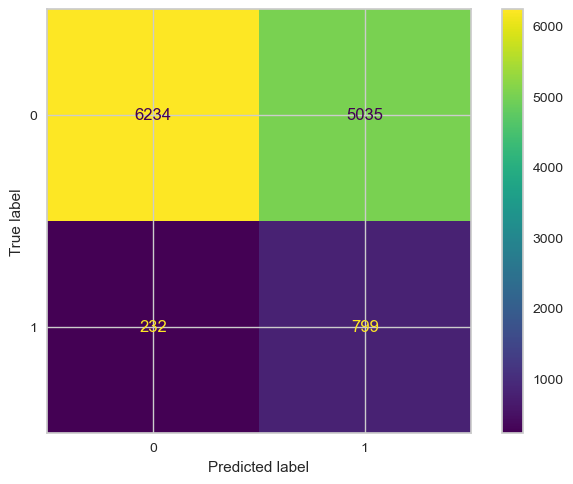

In [185]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

In [186]:
y_pred

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

### Reconstituion du df X_test avec:
- AMNT_GOODS_PRICE
- y_true => y_test
- y_pred => colonne prédictions
- y_proba => en 2 colonnes proba_0 et proba_1 ou une seule colonne sachant que proba_1=1 - proba_0


Ici copier d'abord y_test

In [187]:
X_test['y_true']=y_test
X_test

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship,y_true
214805,348924,0,1,112500.0,272520.0,21658.5,225000.0,1.0,0.549168,0.353125,NaN,55,-0.0,1,1,0,0,0
275393,419189,0,0,90000.0,1125000.0,33021.0,1125000.0,2.0,NaN,0.606080,0.768808,45,11.0,1,1,1,1,0
105291,222187,0,1,112500.0,331920.0,17100.0,225000.0,2.0,NaN,0.617423,0.425893,47,10.0,1,1,1,1,0
39599,145850,0,1,180000.0,270000.0,13500.0,270000.0,4.0,0.638439,0.705071,0.624615,35,4.0,0,1,1,1,0
126990,247276,1,0,90000.0,675000.0,19867.5,675000.0,2.0,NaN,0.608734,0.692559,57,-0.0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149948,273840,0,0,135000.0,545040.0,16654.5,450000.0,3.0,0.735778,0.540847,0.766234,39,4.0,1,1,1,1,0
145533,268757,0,1,103500.0,358443.0,16839.0,252000.0,4.0,0.457444,0.656803,NaN,29,5.0,1,1,1,1,0
168695,295553,0,1,157500.0,728460.0,38938.5,675000.0,1.0,NaN,0.656813,0.782608,54,2.0,1,1,1,0,0
240450,378497,1,1,157500.0,252000.0,18391.5,252000.0,2.0,NaN,0.347194,0.519097,30,4.0,1,1,1,1,0


In [188]:
X_test['predictions']=y_pred
X_test

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship,y_true,predictions
214805,348924,0,1,112500.0,272520.0,21658.5,225000.0,1.0,0.549168,0.353125,NaN,55,-0.0,1,1,0,0,0,1
275393,419189,0,0,90000.0,1125000.0,33021.0,1125000.0,2.0,NaN,0.606080,0.768808,45,11.0,1,1,1,1,0,0
105291,222187,0,1,112500.0,331920.0,17100.0,225000.0,2.0,NaN,0.617423,0.425893,47,10.0,1,1,1,1,0,1
39599,145850,0,1,180000.0,270000.0,13500.0,270000.0,4.0,0.638439,0.705071,0.624615,35,4.0,0,1,1,1,0,0
126990,247276,1,0,90000.0,675000.0,19867.5,675000.0,2.0,NaN,0.608734,0.692559,57,-0.0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149948,273840,0,0,135000.0,545040.0,16654.5,450000.0,3.0,0.735778,0.540847,0.766234,39,4.0,1,1,1,1,0,0
145533,268757,0,1,103500.0,358443.0,16839.0,252000.0,4.0,0.457444,0.656803,NaN,29,5.0,1,1,1,1,0,0
168695,295553,0,1,157500.0,728460.0,38938.5,675000.0,1.0,NaN,0.656813,0.782608,54,2.0,1,1,1,0,0,0
240450,378497,1,1,157500.0,252000.0,18391.5,252000.0,2.0,NaN,0.347194,0.519097,30,4.0,1,1,1,1,0,1


In [189]:
X_test['proba_0']=y_proba[:,0]
X_test

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship,y_true,predictions,proba_0
214805,348924,0,1,112500.0,272520.0,21658.5,225000.0,1.0,0.549168,0.353125,NaN,55,-0.0,1,1,0,0,0,1,0.438421
275393,419189,0,0,90000.0,1125000.0,33021.0,1125000.0,2.0,NaN,0.606080,0.768808,45,11.0,1,1,1,1,0,0,0.735663
105291,222187,0,1,112500.0,331920.0,17100.0,225000.0,2.0,NaN,0.617423,0.425893,47,10.0,1,1,1,1,0,1,0.490012
39599,145850,0,1,180000.0,270000.0,13500.0,270000.0,4.0,0.638439,0.705071,0.624615,35,4.0,0,1,1,1,0,0,0.805716
126990,247276,1,0,90000.0,675000.0,19867.5,675000.0,2.0,NaN,0.608734,0.692559,57,-0.0,1,1,0,1,0,0,0.780984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149948,273840,0,0,135000.0,545040.0,16654.5,450000.0,3.0,0.735778,0.540847,0.766234,39,4.0,1,1,1,1,0,0,0.753534
145533,268757,0,1,103500.0,358443.0,16839.0,252000.0,4.0,0.457444,0.656803,NaN,29,5.0,1,1,1,1,0,0,0.557458
168695,295553,0,1,157500.0,728460.0,38938.5,675000.0,1.0,NaN,0.656813,0.782608,54,2.0,1,1,1,0,0,0,0.682771
240450,378497,1,1,157500.0,252000.0,18391.5,252000.0,2.0,NaN,0.347194,0.519097,30,4.0,1,1,1,1,0,1,0.450273


Ajout de la colonne nb d'annuité qui va nosu permettre de calculer le montant d'interet gagné ou perdu

In [190]:
X_test['nb_annuité']=round(X_test['AMT_CREDIT']/X_test['AMT_ANNUITY'],0)
X_test['nb_annuité'].describe()

count    12299.000000
mean        21.605334
std          7.820104
min          8.000000
25%         16.000000
50%         20.000000
75%         27.000000
max         45.000000
Name: nb_annuité, dtype: float64

In [191]:
X_test.loc[(X_test['y_true']==0) & (X_test['predictions']==1),:].head()

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship,y_true,predictions,proba_0,nb_annuité
214805,348924,0,1,112500.0,272520.0,21658.5,225000.0,1.0,0.549168,0.353125,NaN,55,-0.0,1,1,0,0,0,1,0.438421,13.0
105291,222187,0,1,112500.0,331920.0,17100.0,225000.0,2.0,NaN,0.617423,0.425893,47,10.0,1,1,1,1,0,1,0.490012,19.0
303045,451122,1,0,67500.0,254700.0,27153.0,225000.0,4.0,NaN,0.023481,0.164414,29,8.0,1,1,1,1,0,1,0.111874,9.0
110161,227782,1,1,112500.0,254700.0,26874.0,225000.0,1.0,0.433764,0.751081,0.297087,37,8.0,1,1,1,0,0,1,0.478460,9.0
183724,312962,0,1,112500.0,254700.0,24939.0,225000.0,2.0,NaN,0.245350,NaN,65,-0.0,1,1,0,1,0,1,0.359690,10.0


X_test_2 ci dessous permet de remettre l'index à 0. 
- Plus facile pour tester les différentes fonction de calcul de gain

In [192]:
X_test_2=X_test.copy()

In [193]:
X_test_2.reset_index(inplace=True)

In [194]:
X_test_2.loc[(X_test_2['y_true']==0) & (X_test_2['predictions']==0),:].head()

,index,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship,y_true,predictions,proba_0,nb_annuité
1,275393,419189,0,0,90000.0,1125000.0,33021.0,1125000.0,2.0,NaN,0.606080,0.768808,45,11.0,1,1,1,1,0,0,0.735663,34.0
3,39599,145850,0,1,180000.0,270000.0,13500.0,270000.0,4.0,0.638439,0.705071,0.624615,35,4.0,0,1,1,1,0,0,0.805716,20.0
4,126990,247276,1,0,90000.0,675000.0,19867.5,675000.0,2.0,NaN,0.608734,0.692559,57,-0.0,1,1,0,1,0,0,0.780984,34.0
5,167752,294466,0,1,112500.0,180000.0,18441.0,180000.0,1.0,NaN,0.649546,0.626304,58,-0.0,1,1,0,0,0,0,0.669089,10.0
7,254918,394995,0,0,184500.0,386977.5,11862.0,319500.0,1.0,0.674315,0.447614,0.722393,56,-0.0,1,1,0,0,0,0,0.721005,33.0


In [195]:
def calcul_gain_unit(ser, lost_coeff =0.3, taux=0.05): #y_true, y_pred
    
    '''Le but de cette fonction est de calculer le différentiel de gain grâce au modèle de prédiction comparé à la réalisation dans la vraie vie'''
        
    if ser['predictions']: # ==1 , pas de prêt
        if ser['y_true']: #==1; on ne perd plus d'argent grace au modèle de prédiction: gain
            return round(ser['AMT_CREDIT']-lost_coeff*ser['AMT_GOODS_PRICE'],2)
        else: # y_true = 0: on a refusé le crédit à tort: manque à gagner = interets non perçus = M*i*n (interets simples)
            return round(-(ser['AMT_CREDIT']*taux*ser['nb_annuité']),2)
    if not ser['predictions']: #==0, prêt accordé (pas de différence avec la réalité)
        return 0 
        #if y_true: #==1, prêt non remboursé, donc prêt accordé à tort=> perte = M-(30% * PP)
        #    return -(ser['AMT_CREDIT']-lost_coeff*ser['AMT_GOODS_PRICE'])
        #elif: # y_true = 0 pas de différence : le gain est le même avec et sans modèle de prédiction
        #    return 0
        
            
        

In [196]:
def calcul_gain_unit_1an(ser, lost_coeff =0.3, taux=0.05): #y_true, y_pred
    
    '''Variante de la fn calcul_gain_unit où l'on considère une seule annuité'''
        
    if ser['predictions']: # ==1 , pas de prêt
        if ser['y_true']: #==1; on ne perd plus d'argent grace au modèle de prédiction: gain
            return round(ser['AMT_CREDIT']-lost_coeff*ser['AMT_GOODS_PRICE'],2)
        else: # y_true = 0: on a refusé le crédit à tort: manque à gagner = interets non perçus = M*i*n (interets simples)
            return round(-(ser['AMT_CREDIT']*taux),2)
    if not ser['predictions']: #==0, prêt accordé (pas de différence avec la réalité)
        return 0 

Test fonction calcul_gain_unit

In [197]:
X_test.iloc[19].T

SK_ID_CURR          440918.000000
FLAG_OWN_CAR             0.000000
FLAG_OWN_REALTY          1.000000
AMT_INCOME_TOTAL    202500.000000
AMT_CREDIT          364896.000000
AMT_ANNUITY          19233.000000
AMT_GOODS_PRICE     315000.000000
CNT_FAM_MEMBERS          3.000000
EXT_SOURCE_1             0.246522
EXT_SOURCE_2             0.657375
EXT_SOURCE_3                  NaN
client_age              26.000000
client_prof_exp          2.000000
Cash_loans               1.000000
GENDER_FEMALE            1.000000
active_client            1.000000
relationship             1.000000
y_true                   0.000000
predictions              1.000000
proba_0                  0.466314
nb_annuité              19.000000
Name: 294248, dtype: float64

In [198]:
calcul_gain_unit(X_test.iloc[19].T)

-346651.2

In [199]:
def calcul_gain_total(df):
    df['Gain']=0
    for i in range(len(df)):
        #calcul_gain_unit(df.iloc[i].T)
        df['Gain'].iloc[i]=calcul_gain_unit(df.iloc[i].T)
    return round(df['Gain'].sum(),2)

Test fonction calcul_gain_total

In [200]:
calcul_gain_total(X_test)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-3005086911.67

Montant très négatif. Expliqué par:
- résultats mitigés du modèle (LogReg) => modèle à améliorer
- taux de récup et règle basée sur nb d'annuités 
- par le fait que l'on n'a pas les crédits refusés dans la réalité et qui auraient été octroyés grâce au modèle

Si 1 seule annuité

In [201]:
def calcul_gain_total_1an(df):
    df['Gain']=0
    for i in range(len(df)):
        #calcul_gain_unit(df.iloc[i].T)
        df['Gain'].iloc[i]=calcul_gain_unit_1an(df.iloc[i].T)
    return round(df['Gain'].sum(),2)

In [202]:
calcul_gain_total_1an(X_test)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


183892949.61

Cette fois on gagne

## 6.2 Calcul du gain brut

Version alternative: pour un crédit donné, calcul du gain ou de la perte, en focntion de la prédictions. Pas de notion de perte évitée ou de manque à gagner

In [203]:
def calcul_gain_gross(ser, lost_coeff =0.3, taux=0.05): #y_true, y_pred
    
    if ser['predictions']:
        return 0
    
    if not ser['y_true']: # == 0 > prêt accordé et remboursé: gains = interets
        return round(ser['AMT_CREDIT']*taux*ser['nb_annuité'],2)
    
    if ser['y_true']: # ==1 prêt accordé à tort : perte K  - vente des biens
        return round(-ser['AMT_CREDIT']-lost_coeff * ser['AMT_GOODS_PRICE'],2)

Test de la fn calcul_gain_gross

In [204]:
calcul_gain_gross(X_test.iloc[19].T)

0

In [205]:
X_test.iloc[0].T

SK_ID_CURR          348924.000000
FLAG_OWN_CAR             0.000000
FLAG_OWN_REALTY          1.000000
AMT_INCOME_TOTAL    112500.000000
AMT_CREDIT          272520.000000
AMT_ANNUITY          21658.500000
AMT_GOODS_PRICE     225000.000000
CNT_FAM_MEMBERS          1.000000
EXT_SOURCE_1             0.549168
EXT_SOURCE_2             0.353125
EXT_SOURCE_3                  NaN
client_age              55.000000
client_prof_exp         -0.000000
Cash_loans               1.000000
GENDER_FEMALE            1.000000
active_client            0.000000
relationship             0.000000
y_true                   0.000000
predictions              1.000000
proba_0                  0.438421
nb_annuité              13.000000
Gain                -13626.000000
Name: 214805, dtype: float64

In [206]:
calcul_gain_gross(X_test.iloc[0].T)

0

In [207]:
#gain=[]

In [208]:
def calcul_gain_total_1an(df):
    df['Gain']=0
    for i in range(len(df)):
        #calcul_gain_unit(df.iloc[i].T)
        df['Gain'].iloc[i]=calcul_gain_unit_1an(df.iloc[i].T)
    return round(df['Gain'].sum(),2)

In [209]:
#gain

In [210]:
def calcul_gain_gross_total(df):
    gain=[]
    gain_total = 0
    for i in range(len(df)):
        gain.append(calcul_gain_gross(df.iloc[i].T))
        
        #df['Gain_net'].iloc[i]=calcul_gain_unit(df.iloc[i].T)
        gain_total+=gain[i]
    return round(gain_total,2)

In [211]:
calcul_gain_gross_total(X_test)

5075807078.23

!!!! Ne fonctionne plus => A revoir

## 6.3 Optimisation du seuil de proba définissant que le crédit sera remboursé

In [212]:
def calcul_gain_proba_unit(ser,seuil=0.50, lost_coeff =0.3, taux=0.05): 
    
    if ser['proba_0'] < seuil:
        return 0    
            
    #if ser['predictions']:
    #    return 0
    
    
    
    if not ser['y_true']: # == 0 > prêt accordé et remboursé: gains = interets
        #Version où les interets sont perçus sur toutes les annuités
        #return round(ser['AMT_CREDIT']*taux*ser['nb_annuité'],2)
        
        #Version où l'on ne perçoit les int qu'une seule fois
        return round(ser['AMT_CREDIT']*taux,2)
    
    if ser['y_true']: # ==1 prêt accordé à tort : perte K  - vente des biens
        return round(-ser['AMT_CREDIT']-lost_coeff * ser['AMT_GOODS_PRICE'],2)

In [213]:
X_test_2.loc[(X_test_2['y_true']==0) & (X_test_2['predictions']==1),:].head()

,index,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship,y_true,predictions,proba_0,nb_annuité
0,214805,348924,0,1,112500.0,272520.0,21658.5,225000.0,1.0,0.549168,0.353125,NaN,55,-0.0,1,1,0,0,0,1,0.438421,13.0
2,105291,222187,0,1,112500.0,331920.0,17100.0,225000.0,2.0,NaN,0.617423,0.425893,47,10.0,1,1,1,1,0,1,0.490012,19.0
6,303045,451122,1,0,67500.0,254700.0,27153.0,225000.0,4.0,NaN,0.023481,0.164414,29,8.0,1,1,1,1,0,1,0.111874,9.0
10,110161,227782,1,1,112500.0,254700.0,26874.0,225000.0,1.0,0.433764,0.751081,0.297087,37,8.0,1,1,1,0,0,1,0.478460,9.0
12,183724,312962,0,1,112500.0,254700.0,24939.0,225000.0,2.0,NaN,0.245350,NaN,65,-0.0,1,1,0,1,0,1,0.359690,10.0


In [214]:
X_test_2.iloc[1].T

index               2.753930e+05
SK_ID_CURR          4.191890e+05
FLAG_OWN_CAR        0.000000e+00
FLAG_OWN_REALTY     0.000000e+00
AMT_INCOME_TOTAL    9.000000e+04
AMT_CREDIT          1.125000e+06
AMT_ANNUITY         3.302100e+04
AMT_GOODS_PRICE     1.125000e+06
CNT_FAM_MEMBERS     2.000000e+00
EXT_SOURCE_1                 NaN
EXT_SOURCE_2        6.060801e-01
EXT_SOURCE_3        7.688076e-01
client_age          4.500000e+01
client_prof_exp     1.100000e+01
Cash_loans          1.000000e+00
GENDER_FEMALE       1.000000e+00
active_client       1.000000e+00
relationship        1.000000e+00
y_true              0.000000e+00
predictions         0.000000e+00
proba_0             7.356632e-01
nb_annuité          3.400000e+01
Name: 1, dtype: float64

In [215]:
calcul_gain_proba_unit(X_test.iloc[1].T,seuil=0.1)

56250.0

In [216]:
#calcul_gain_unit(X_test.iloc[2].T)

In [217]:
calcul_gain_gross(X_test.iloc[1].T)

1912500.0

In [218]:
#def calcul_seuil_optimal(df):
#    best_thresh=pd.DataFrame(columns=['threshold','Gain_total'])
#    for thr,j in zip(np.arange(0,1,0.1),range(len(np.arange(0,1,0.1)))): 
#        gain=[]
#        gain_total = 0
      
#        for i in range(len(df)):
#            gain.append(calcul_gain_proba_unit(df.iloc[i].T,thr))
#            gain_total+=gain[i]

#        tmp=pd.DataFrame([[round(thr,1),gain_total]],columns=['threshold','Gain_total'])
#        
#        best_thresh=pd.concat([best_thresh,tmp],axis=0,ignore_index=True)

#    return best_thresh #gain_total

In [219]:
def calcul_seuil_optimal(df):
    best_thresh=pd.DataFrame(columns=['threshold','Gain_total'])
    #global best_thresh
    
    for thr,j in zip(np.arange(0,1,0.05),range(len(np.arange(0,1,0.05)))): 
        gain=[]
        gain_total = 0
        
        for i in range(len(df)):
            gain.append(calcul_gain_proba_unit(df.iloc[i].T,thr,taux=0.04,lost_coeff=0.3))
            gain_total+=gain[i]
        
        tmp=pd.DataFrame([[round(thr,2),gain_total]],columns=['threshold','Gain_total'])
        
        best_thresh=pd.concat([best_thresh,tmp],axis=0,ignore_index=True)
        
    return best_thresh #gain_total

In [220]:
thresh=calcul_seuil_optimal(X_test)
thresh

,threshold,Gain_total
0,0.00,-4.650013e+08
1,0.05,-4.591375e+08
2,0.10,-4.286415e+08
3,0.15,-3.768326e+08
4,0.20,-3.123004e+08
5,0.25,-2.466124e+08
6,0.30,-1.876146e+08
7,0.35,-1.484206e+08
8,0.40,-8.692175e+07
9,0.45,-4.929796e+07


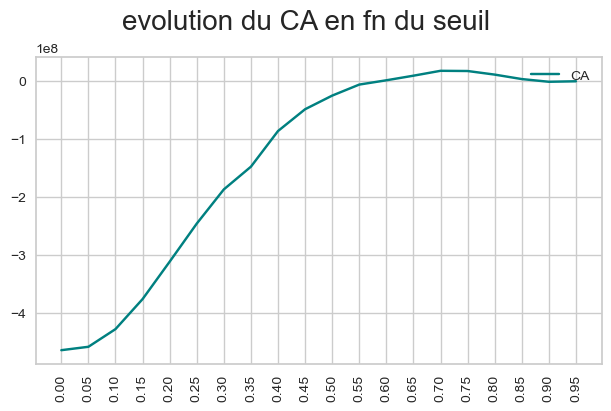

In [221]:
fig = plt.figure(figsize=(6,4),constrained_layout = True)
plt.plot(thresh['threshold'],thresh['Gain_total'], color='teal', label='CA')
#plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
listOf_Xticks = thresh['threshold']
plt.xticks(listOf_Xticks,rotation='vertical')
fig.suptitle('evolution du CA en fn du seuil', fontsize=20)
plt.legend(loc="upper right")
plt.show()

In [222]:
thresh['Gain_total'].max()

16998895.080000024

In [223]:
thresh.loc[thresh['Gain_total']==thresh['Gain_total'].max(),:]

,threshold,Gain_total
14,0.7,16998895.08


# 7.Préparation modèle et df pour API

In [224]:
X_train

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
274603,418295,0,1,135000.0,270000.0,28480.5,270000.0,2.0,NaN,0.559009,0.788681,60,-0.0,1,1,0,1
106019,223016,0,0,157500.0,360000.0,9900.0,360000.0,2.0,NaN,0.631753,0.636376,42,2.0,1,1,1,1
216416,350782,0,1,112500.0,270000.0,13500.0,270000.0,1.0,0.238026,0.061174,NaN,22,1.0,0,1,1,0
152732,277028,0,1,180000.0,1552500.0,47200.5,1552500.0,1.0,NaN,0.655200,NaN,50,1.0,1,0,1,0
273745,417317,0,1,270000.0,1007761.5,39964.5,927000.0,2.0,NaN,0.631676,0.695622,45,4.0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260413,401386,0,1,90000.0,468733.5,26302.5,387000.0,4.0,NaN,0.293044,0.665855,42,20.0,1,1,1,1
89028,203380,0,1,166500.0,781920.0,34443.0,675000.0,2.0,NaN,0.093157,0.513694,49,21.0,1,0,1,1
260753,401779,0,0,99000.0,1575000.0,41679.0,1575000.0,2.0,NaN,0.745114,0.479449,55,9.0,1,1,1,1
129646,250382,1,0,225000.0,1024290.0,29484.0,855000.0,3.0,0.702900,0.672626,0.450747,48,3.0,1,0,1,1


In [225]:
X_train.dtypes

SK_ID_CURR            int64
FLAG_OWN_CAR          int64
FLAG_OWN_REALTY       int64
AMT_INCOME_TOTAL    float64
AMT_CREDIT          float64
AMT_ANNUITY         float64
AMT_GOODS_PRICE     float64
CNT_FAM_MEMBERS     float64
EXT_SOURCE_1        float64
EXT_SOURCE_2        float64
EXT_SOURCE_3        float64
client_age            int64
client_prof_exp     float64
Cash_loans            int64
GENDER_FEMALE         int64
active_client         int64
relationship          int64
dtype: object

In [226]:
X_train.columns.to_list()

['SK_ID_CURR',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'client_age',
 'client_prof_exp',
 'Cash_loans',
 'GENDER_FEMALE',
 'active_client',
 'relationship']

In [227]:
best_model

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator', LogisticRegression())])

Définr le seuil à 0.65 pour predicts dans best_model

Serialisation pour API

In [228]:
### Create a Pickle file using serialization 
#import pickle
#pickle_out = open("classifier.pkl","wb")
#pickle.dump(best_model, pickle_out)
#pickle_out.close()

In [229]:
# cette version ne fonctionne pas dans l'API. Ci dessous corretion avec .to_pickle()
#pickle_data = open("data.pkl","wb")
#pickle.dump(X, pickle_data)
#pickle_out.close()

In [230]:
X_tmp.head(5)

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
225171,360832,0,1,252000.0,509922.0,26401.5,472500.0,1.0,NaN,0.674957,0.477649,47,2.0,1,1,1,0
20729,124160,0,1,126000.0,942300.0,30528.0,675000.0,1.0,NaN,0.119868,0.367291,60,-0.0,1,1,0,0
191982,322634,0,1,180000.0,619965.0,24151.5,517500.0,2.0,0.615425,0.478017,0.570917,43,4.0,1,1,1,1
119194,238220,1,0,270000.0,582768.0,54616.5,540000.0,2.0,NaN,0.588430,0.520898,47,3.0,1,0,1,1
60779,170489,0,1,112500.0,500211.0,34942.5,463500.0,2.0,0.584978,0.758451,0.639708,31,0.0,1,1,1,1


In [231]:
X.head(5)

,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
225171,0,1,252000.0,509922.0,26401.5,1.0,NaN,0.674957,0.477649,47,2.0,1,1,1,0
20729,0,1,126000.0,942300.0,30528.0,1.0,NaN,0.119868,0.367291,60,-0.0,1,1,0,0
191982,0,1,180000.0,619965.0,24151.5,2.0,0.615425,0.478017,0.570917,43,4.0,1,1,1,1
119194,1,0,270000.0,582768.0,54616.5,2.0,NaN,0.588430,0.520898,47,3.0,1,0,1,1
60779,0,1,112500.0,500211.0,34942.5,2.0,0.584978,0.758451,0.639708,31,0.0,1,1,1,1


Serialisation depuis pd.to_picle()


In [232]:
X_tmp.to_pickle("./data2pkl.pkl")

In [233]:
X_tmp.to_csv('C:/Users/xavie/P7/P7_API/data_sample.csv', index=False)

In [234]:
X_tmp.shape

(61498, 17)

In [235]:
X_tmp.head(5)

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
225171,360832,0,1,252000.0,509922.0,26401.5,472500.0,1.0,NaN,0.674957,0.477649,47,2.0,1,1,1,0
20729,124160,0,1,126000.0,942300.0,30528.0,675000.0,1.0,NaN,0.119868,0.367291,60,-0.0,1,1,0,0
191982,322634,0,1,180000.0,619965.0,24151.5,517500.0,2.0,0.615425,0.478017,0.570917,43,4.0,1,1,1,1
119194,238220,1,0,270000.0,582768.0,54616.5,540000.0,2.0,NaN,0.588430,0.520898,47,3.0,1,0,1,1
60779,170489,0,1,112500.0,500211.0,34942.5,463500.0,2.0,0.584978,0.758451,0.639708,31,0.0,1,1,1,1


In [237]:
X_tmp.loc[X_tmp['SK_ID_CURR']==100003,:]

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,2.0,0.311267,0.622246,NaN,45,3.0,1,1,1,1


Serialisation du tranformateur pour Shap (best_model auquel je retire la dernière étape)

In [238]:
best_model[-1]

LogisticRegression()

In [239]:
best_model[:-1]

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [242]:
type(shap_values)

shap._explanation.Explanation

In [248]:
shap_values.shape

(7846, 15)

In [243]:
explainer

In [ ]:
explainer()